In [1]:
import pandas as pd
import numpy as np
from urllib.request import urlopen
from PIL import Image
import timm
import torch
from tqdm import tqdm
import ast
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt

/Users/veeranonthuvasin/Desktop/MSc-Data-Science-Bristol/Dissertation/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
writers_info = pd.read_csv('./Final-Data/new-writers-info.csv')
english_writer_info = pd.read_csv('../Data/Bristol-Corpus/English-GrayScale/english_df.csv')

writers_info = pd.concat([writers_info, english_writer_info], axis=0, ignore_index=True)
writers_info = writers_info.loc[writers_info['NativeLanguage'] != 'Swiss German']

writers_info

,name,DayOfBirth,EducationalDegree,Gender,NativeCountry,NativeLanguage,OtherLanguage,Profession,WritingType,Science,WrittenLanguage,ascii_path,images_path,stroke_path
0,10000,1982-06-08,Dipl. Inform.,Male,Germany,German,French,PhD-Student,Right-handed,Mathematics,English,"['./Data/ascii/z01/z01-000/z01-000.txt', './Da...",['./Data/lineImages/z01/z01-000/z01-000-*.tif'...,['./Data/lineStrokes/z01/z01-000/z01-000-*.xml...
1,10002,NaN,NaN,Male,Great Britain,English,NaN,NaN,Right-handed,NaN,English,"['./Data/ascii/a01/a01-020/a01-020x.txt', './D...",['./Data/lineImages/a01/a01-020/a01-020x-*.tif...,['./Data/lineStrokes/a01/a01-020/a01-020x-*.xm...
2,10004,NaN,NaN,Male,France,French,NaN,NaN,Right-handed,NaN,English,"['./Data/ascii/a02/a02-082/a02-082.txt', './Da...",['./Data/lineImages/a02/a02-082/a02-082-*.tif'...,['./Data/lineStrokes/a02/a02-082/a02-082-*.xml...
3,10007,NaN,NaN,Male,France,French,NaN,NaN,Right-handed,NaN,English,"['./Data/ascii/a01/a01-014/a01-014.txt', './Da...",['./Data/lineImages/a01/a01-014/a01-014-*.tif'...,['./Data/lineStrokes/a01/a01-014/a01-014-*.xml...
4,10008,NaN,NaN,Male,France,French,NaN,NaN,Right-handed,NaN,English,"['./Data/ascii/a01/a01-077/a01-077.txt', './Da...",['./Data/lineImages/a01/a01-077/a01-077-*.tif'...,['./Data/lineStrokes/a01/a01-077/a01-077-*.xml...
5,10009,NaN,NaN,Male,Germany,German,NaN,NaN,Right-handed,NaN,English,"['./Data/ascii/a01/a01-003/a01-003.txt', './Da...",['./Data/lineImages/a01/a01-003/a01-003-*.tif'...,['./Data/lineStrokes/a01/a01-003/a01-003-*.xml...
6,10010,NaN,NaN,Male,Switzerland,French,English,NaN,Right-handed,NaN,French,"['./Data/ascii/a01/a01-117/a01-117.txt', './Da...",['./Data/lineImages/a01/a01-117/a01-117-*.tif'...,['./Data/lineStrokes/a01/a01-117/a01-117-*.xml...
7,10011,NaN,NaN,Male,Switzerland,French,NaN,NaN,Right-handed,NaN,English,"['./Data/ascii/a01/a01-000/a01-000u.txt', './D...",['./Data/lineImages/a01/a01-000/a01-000u-*.tif...,['./Data/lineStrokes/a01/a01-000/a01-000u-*.xm...
8,10012,NaN,NaN,Male,Switzerland,French,NaN,NaN,Right-handed,NaN,English,"['./Data/ascii/a01/a01-003/a01-003x.txt', './D...",['./Data/lineImages/a01/a01-003/a01-003x-*.tif...,['./Data/lineStrokes/a01/a01-003/a01-003x-*.xm...
9,10015,NaN,NaN,Female,Switzerland,French,English,NaN,Right-handed,NaN,French,"['./Data/ascii/a01/a01-020/a01-020.txt', './Da...",['./Data/lineImages/a01/a01-020/a01-020-*.tif'...,['./Data/lineStrokes/a01/a01-020/a01-020-*.xml...


In [ ]:
writers_info['NativeLanguage'].value_counts()

NativeLanguage
English    22
German     19
French     16
Name: count, dtype: int64

# Utility Functions
- Feature Extraction Functions
- Change writer label

In [ ]:
def feature_extraction(writer_name, images_path):
  model = timm.create_model(
      'convnextv2_nano.fcmae_ft_in22k_in1k',
      pretrained=True,
      num_classes=0,  # remove classifier nn.Linear
  )
  model = model.eval()

  data_config = timm.data.resolve_model_data_config(model)
  transforms = timm.data.create_transform(**data_config, is_training=False)

  all_features_data = []
  writer_id_list = []
  writer_forms_list = []
  for name, i in tqdm(zip(writer_name,images_path)):
      i = ast.literal_eval(i)
      for j in i:
        j = j.replace('./', '../')
        image_list = glob.glob(j)
        for k in image_list:
          with Image.open(k) as img:
              img = img.convert('RGB')

              with torch.no_grad():
                  output = model(transforms(img).unsqueeze(0))
              # print(output)
              # features = output.pooler_output.detach().numpy()
              # print(features)
              # last_hidden_states = outputs.last_hidden_state
              # print(last_hidden_states.shape)
              # features = last_hidden_states[:, 0, :]
              # print(features)
              # Store the results
              image_form = os.path.splitext(os.path.basename(k))[0]
              writer_forms_list.append(image_form)
              writer_id_list.append(name)
              all_features_data.append(output.detach().flatten().tolist())
                  

              


  writer_features_df = pd.DataFrame(data=all_features_data)
  writer_features_df['name'] = writer_id_list
  writer_features_df['form'] = writer_forms_list

  return writer_features_df

def convert_y(y):
  if y == 'German':
    return 0
  if y == 'French': 
    return 1
  if y == 'English':
    return 2

# Feature Extraction Full

In [ ]:
all_features = feature_extraction(writers_info['name'], writers_info['images_path'])
all_features

In [ ]:
all_features.to_csv('./Final-Data/All-Writers-Feature-Vectors-GrayScale.csv')

# Feature Extraction for Training Set (class-wise fixed images_per_subwrite sizes and bootstrapping, but dynamic sub_profile_per_writer)
- 4 Sentence-Level Images per Sub-writer Profile for English, creating 3 Sub-writer Profiles.
- 4 Sentence-Level Images per Sub-writer Profile for German/French, creating 12 Sub-writer Profiles.

In [ ]:
def create_sub_writers_bootstrap(train_df, feature_store, images_per_subwriter=4, fold_seed=42):
  
    writer_names_in_fold = train_df['name'].unique()
    feature_df = feature_store[feature_store['name'].isin(writer_names_in_fold)]

    feature_columns = [col for col in feature_df.columns if col not in ['name', 'form']]
    aggregated_data = []
    
    unique_writers = feature_df['name'].unique()
    
    for writer_id in unique_writers:
        writer_df = feature_df[feature_df['name'] == writer_id]
        num_images = len(writer_df)
        
        if num_images == 0:
            continue


        try:
            language = train_df.loc[train_df['name'] == writer_id, 'NativeLanguage'].iloc[0]
        except IndexError:
            print(f"Warning: Could not find language for writer_id {writer_id}. Skipping.")
            continue

        if language == 'English':
            current_num_profiles_per_writer = 3  # Create fewer profiles for the low-data class
        else:  # For German and French
            current_num_profiles_per_writer = 12 # Create more profiles for the high-data classes


        if num_images <= images_per_subwriter:
            feature_chunk = writer_df[feature_columns]
            mean_features = feature_chunk.mean(axis=0)
            median_features = feature_chunk.median(axis=0)
            std_features = feature_chunk.std(axis=0).fillna(0)
            skew_features = feature_chunk.skew(axis=0).fillna(0)
            
            new_row = {}
            for col in feature_columns:
                new_row[f'{col}|mean'] = mean_features[col]
                new_row[f'{col}|median'] = median_features[col]
                new_row[f'{col}|std'] = std_features[col]
                new_row[f'{col}|skew'] = skew_features[col]
                
            new_row['original_writer_id'] = writer_id
            new_row['sub_writer_id'] = f"{writer_id}-agg-0"
            aggregated_data.append(new_row)
            continue

        writer_profiles = []
        max_attempts = current_num_profiles_per_writer * 5
        
        for i in range(max_attempts):
            sample_chunk = writer_df.sample(
                n=images_per_subwriter, 
                replace=True, 
                random_state=fold_seed + hash(writer_id) % 100000 + i
            )
            feature_chunk = sample_chunk[feature_columns]
            
            mean_features = feature_chunk.mean(axis=0)
            median_features = feature_chunk.median(axis=0)
            std_features = feature_chunk.std(axis=0).fillna(0)
            skew_features = feature_chunk.skew(axis=0).fillna(0)
            
            profile_dict = {}
            for col in feature_columns:
                profile_dict[f'{col}|mean'] = mean_features[col]
                profile_dict[f'{col}|median'] = median_features[col]
                profile_dict[f'{col}|std'] = std_features[col]
                profile_dict[f'{col}|skew'] = skew_features[col]
                
            writer_profiles.append(profile_dict)
            
            temp_df = pd.DataFrame(writer_profiles).drop_duplicates()
            if len(temp_df) >= current_num_profiles_per_writer:
                break
        
        if writer_profiles:
            profiles_df = pd.DataFrame(writer_profiles)
            unique_profiles_df = profiles_df.drop_duplicates().reset_index(drop=True)
            final_profiles_df = unique_profiles_df.head(current_num_profiles_per_writer)

            for i, row in final_profiles_df.iterrows():
                profile_data = row.to_dict()
                profile_data['original_writer_id'] = writer_id
                profile_data['sub_writer_id'] = f"{writer_id}-boot-{i}"
                aggregated_data.append(profile_data)
            
    final_df = pd.DataFrame(aggregated_data)
    
    if final_df.empty:
        return pd.DataFrame(), pd.Series(dtype='int')


    new_feature_columns = []
    for col in feature_columns:
        new_feature_columns.append(f'{col}|mean')
        new_feature_columns.append(f'{col}|median')
        new_feature_columns.append(f'{col}|std')
        new_feature_columns.append(f'{col}|skew')

    cols = ['sub_writer_id', 'original_writer_id'] + new_feature_columns
    final_df = final_df[cols]
    
    final_df = pd.merge(final_df, train_df[['name', 'NativeLanguage']], how='inner', left_on='original_writer_id', right_on='name')
    
    X_train = final_df.drop(columns=['sub_writer_id', 'original_writer_id','name','NativeLanguage'])
    y_train = final_df['NativeLanguage']
    y_train = np.vectorize(convert_y)(y_train)
    
    return X_train, y_train

# Feature Extraction for Test set (Writer-Level Profile)

In [ ]:
def create_writer_level_profile(test_df, feature_store):
  
  writer_names_in_fold = test_df['name'].unique()
  test_features_df = feature_store[feature_store['name'].isin(writer_names_in_fold)]
  
  writer_level_feature_df = test_features_df.groupby(['name'], as_index=False)[test_features_df.columns[:-2]].agg(['mean', 'median', 'std', 'skew']).fillna(0)
  writer_level_feature_df.columns = writer_level_feature_df.columns.map(lambda x: '|'.join(map(str, x)))
  
  final_test_df = pd.merge(writer_level_feature_df, test_df[['name', 'NativeLanguage']], how='inner', left_on='name|', right_on='name')
  
  X_test = final_test_df.drop(columns=['name','name|','NativeLanguage'])
  y_test = final_test_df['NativeLanguage']
  y_test = np.vectorize(convert_y)(y_test)
  
  return X_test, y_test
  
  

## Distribution of Each Sentence-level Images Per Writer Per Class

,name,cnt
count,19.000000,19.000000
mean,10112.473684,60.000000
std,67.104701,19.407902
min,10000.000000,12.000000
25%,10071.500000,53.000000
50%,10104.000000,58.000000
75%,10164.500000,64.000000
max,10220.000000,113.000000


,name,cnt
count,16.000000,16.000000
mean,10045.437500,90.187500
std,68.685728,28.100341
min,10004.000000,45.000000
25%,10010.750000,68.750000
50%,10017.500000,100.000000
75%,10026.000000,110.000000
max,10219.000000,129.000000


,name,cnt
count,22.000000,22.000000
mean,467.227273,11.727273
std,2129.633971,17.216221
min,0.000000,5.000000
25%,7.250000,6.000000
50%,13.500000,7.500000
75%,20.500000,9.750000
max,10002.000000,88.000000


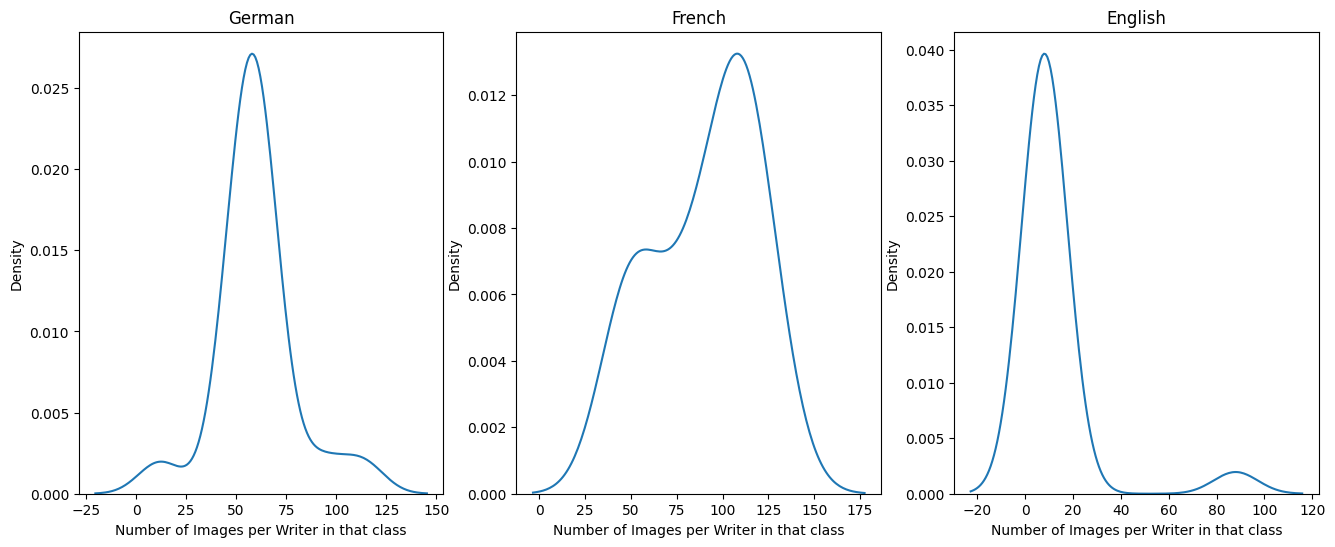

In [ ]:
feature_store = pd.read_csv('./Final-Data/All-Writers-Feature-Vectors-GrayScale.csv', index_col=[0])
images_per_writer_per_class = feature_store[['name']]
images_per_writer_per_class = pd.merge(images_per_writer_per_class, writers_info[['name', 'NativeLanguage']], how='inner', on='name')

images_per_writer_per_class['cnt'] = 1
images_per_writer_per_class_group = images_per_writer_per_class.groupby(['name','NativeLanguage'], as_index=False).sum()
# display(images_per_writer_per_class_group)

fig, axes = plt.subplots(1, 3, figsize=(16,6))

sns.kdeplot(data=images_per_writer_per_class_group.loc[images_per_writer_per_class_group['NativeLanguage'] == 'German']['cnt'], ax=axes[0])
sns.kdeplot(data=images_per_writer_per_class_group.loc[images_per_writer_per_class_group['NativeLanguage'] == 'French']['cnt'], ax=axes[1])
sns.kdeplot(data=images_per_writer_per_class_group.loc[images_per_writer_per_class_group['NativeLanguage'] == 'English']['cnt'], ax=axes[2])

axes[0].set_title('German')
axes[0].set_xlabel('Number of Images per Writer in that class')
axes[1].set_title('French')
axes[1].set_xlabel('Number of Images per Writer in that class')
axes[2].set_title('English')
axes[2].set_xlabel('Number of Images per Writer in that class')

display(images_per_writer_per_class_group.loc[images_per_writer_per_class_group['NativeLanguage'] == 'German'].describe())
display(images_per_writer_per_class_group.loc[images_per_writer_per_class_group['NativeLanguage'] == 'French'].describe())
display(images_per_writer_per_class_group.loc[images_per_writer_per_class_group['NativeLanguage'] == 'English'].describe())



# Nested Cross-Validation

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
import optuna
from optuna.distributions import FloatDistribution, IntDistribution
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from imblearn.metrics import geometric_mean_score
import json
from collections import defaultdict


feature_store = pd.read_csv('./Final-Data/All-Writers-Feature-Vectors-GrayScale.csv', index_col=[0])
all_writers_info = feature_store[['name']].drop_duplicates().reset_index(drop=True)
all_writers_info = pd.merge(all_writers_info, writers_info[['name', 'NativeLanguage']], how='inner', on='name')
all_labels = all_writers_info['NativeLanguage']


# Define the cross-validation splitters

outer_cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=42)
inner_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=42)

results_aggregator = {
    '0': {'precision': [], 'recall': [], 'f1-score': [], 'support': []},
    '1': {'precision': [], 'recall': [], 'f1-score': [], 'support': []},
    '2': {'precision': [], 'recall': [], 'f1-score': [], 'support': []},
    'accuracy': [],
    'g_mean': [],
    'confusion_matrices': []
}

outer_loop_scores = []
writer_level_results = defaultdict(lambda: {'true': [], 'predicted': []})
print("--- Starting Nested Cross-Validation ---")

# --- The Outer Loop ---
for i, (outer_train_idx, outer_test_idx) in enumerate(outer_cv.split(all_writers_info, all_labels)):
    outer_test_writers = all_writers_info.iloc[outer_test_idx]
    print("-" * 50)
    print(f"DEBUG: Writers in Outer Test Fold {i+1}: {sorted(outer_test_writers['name'].tolist())}")
    print("-" * 50)
    
    print(f"\nOuter Fold {i+1}/5")
    outer_train_writers, outer_train_labels = all_writers_info.iloc[outer_train_idx], all_labels.iloc[outer_train_idx]
    outer_test_writers, outer_test_labels = all_writers_info.iloc[outer_test_idx], all_labels.iloc[outer_test_idx]
    # display(outer_train_writers)
    # display(outer_train_labels)
    # print(outer_train_writers.shape)
    # print(outer_train_labels.shape)
    # print(outer_test_writers.shape)
    # --- The Inner Loop using Optuna ---
    def objective(trial):
        params = {
            'feature_selection__max_features': trial.suggest_int('feature_selection__max_features', 10, 1000),
            'classification__n_estimators': trial.suggest_int('classification__n_estimators', 50, 1000),
            'classification__learning_rate': trial.suggest_float('classification__learning_rate', 1e-3, 0.5, log=True),
            'classification__max_depth': trial.suggest_int('classification__max_depth', 3, 15),
            'classification__subsample': trial.suggest_float('classification__subsample', 0.6, 1.0),
            'classification__colsample_bytree': trial.suggest_float('classification__colsample_bytree', 0.6, 1.0),
            'classification__lambda': trial.suggest_float('classification__lambda', 0.1, 30.0, log=True),
            'classification__alpha': trial.suggest_float('classification__alpha', 0.1, 20.0, log=True),
            'classification__min_child_weight': trial.suggest_int('classification__min_child_weight', 1, 10)
        }

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=42)),
            ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
            ('classification', XGBClassifier(random_state=42, eval_metric='mlogloss'))
        ])
        pipeline.set_params(**params)

        # Perform inner cross-validation to evaluate this pipeline configuration
        inner_scores = []
        for j, (inner_train_idx, inner_val_idx) in enumerate(inner_cv.split(outer_train_writers, outer_train_labels)):
            print(f"    - Trial #{trial.number}, Inner Fold {j+1}/{inner_cv.get_n_splits()}", end='\r')
            inner_train_writers = outer_train_writers.iloc[inner_train_idx]
            inner_val_writers = outer_train_writers.iloc[inner_val_idx]
            # display(inner_train_writers)

            X_inner_train, y_inner_train = create_sub_writers_bootstrap(inner_train_writers, feature_store, fold_seed=j)
            X_inner_val, y_inner_val = create_sub_writers_bootstrap(inner_val_writers, feature_store, fold_seed=j+1000)
            # display(X_inner_train)
            # display(X_inner_val)
            pipeline.fit(X_inner_train, y_inner_train)
            preds = pipeline.predict(X_inner_val)
            inner_scores.append(f1_score(y_inner_val, preds, average='macro'))
        
        # print(inner_scores)
        return np.mean(inner_scores)

    # Create and run the Optuna study to find the best params for this outer fold
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=15) 
    best_hyperparams = study.best_params
    print(f"  --- Optuna Complete. Best params for this fold: {best_hyperparams} ---")

    # --- Final Training and Evaluation for this Outer Fold ---
    
    X_train_fold, y_train_fold = create_sub_writers_bootstrap(outer_train_writers, feature_store, fold_seed=i)
    X_test_fold, y_test_fold = create_writer_level_profile(outer_test_writers, feature_store)
    
    print(f"\n--- DEBUG DATA FOR FOLD {i+1} ---")
    print(f"Shape of final X_train_fold: {X_train_fold.shape}")
    print(f"Shape of final X_test_fold: {X_test_fold.shape}")

    print(f"Sum of final X_test_fold values: {X_test_fold.to_numpy().sum()}") 
    print("---------------------------------\n")

    

    final_fold_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
        ('classification', XGBClassifier(random_state=42, eval_metric='mlogloss'))
    ])
    final_fold_pipeline.set_params(**best_hyperparams)
    
    final_fold_pipeline.fit(X_train_fold, y_train_fold)
    
    predictions = final_fold_pipeline.predict(X_test_fold)
    
    # --- Log the result for each writer in this test fold ---
    test_writer_ids = outer_test_writers['name'].tolist()
    
    for idx, writer_id in enumerate(test_writer_ids):
        true_label = y_test_fold[idx]
        predicted_label = predictions[idx]
        writer_level_results[writer_id]['true'].append(true_label)
        writer_level_results[writer_id]['predicted'].append(predicted_label)
        
    report = classification_report(y_test_fold, predictions, output_dict=True, zero_division=0)
    g_mean = geometric_mean_score(y_test_fold, predictions, average='macro')
    cm = confusion_matrix(y_test_fold, predictions, labels=[0, 1, 2])
    
    for class_label in ['0', '1', '2']:
        if class_label in report:
            for metric in ['precision', 'recall', 'f1-score', 'support']:
                results_aggregator[class_label][metric].append(report[class_label][metric])
    
    results_aggregator['accuracy'].append(report['accuracy'])
    results_aggregator['g_mean'].append(g_mean)
    results_aggregator['confusion_matrices'].append(cm.tolist())
    
    print(f"  --> Score for this fold (Macro F1): {report['macro avg']['f1-score']:.4f}, (G-Mean): {g_mean:.4f}, (Accuracy): {report['accuracy']}")

    # --- Save progress at the end of each fold ---
    print("  -> Saving progress to cv_results.json...")
    with open('GrayScale-cv_results_dynamic_subprofiles_fixed_img4_4fold-12sub-Corrected.json', 'w') as f:
        json.dump(results_aggregator, f, indent=4)
    
    # score = f1_score(y_test_fold, predictions, average='macro')
    # outer_loop_scores.append(score)
    # print(f"  Score for Outer Fold {i+1}: {score:.4f}")
    


[I 2025-08-12 22:26:36,042] A new study created in memory with name: no-name-619434f4-11dd-4d5f-9e23-b6fbd59420c1


--- Starting Nested Cross-Validation ---
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 1: [7, 11, 14, 19, 21, 25, 10000, 10004, 10008, 10032, 10052, 10089, 10108, 10109, 10164]
--------------------------------------------------

Outer Fold 1/5


[I 2025-08-12 22:28:39,818] Trial 0 finished with value: 0.6893596865915809 and parameters: {'feature_selection__max_features': 407, 'classification__n_estimators': 572, 'classification__learning_rate': 0.04923727595180747, 'classification__max_depth': 5, 'classification__subsample': 0.9737203372858438, 'classification__colsample_bytree': 0.6308790327578033, 'classification__lambda': 0.7921484526018578, 'classification__alpha': 4.554447094464664, 'classification__min_child_weight': 1}. Best is trial 0 with value: 0.6893596865915809.


[I 2025-08-12 22:30:53,287] Trial 1 finished with value: 0.6801948322261634 and parameters: {'feature_selection__max_features': 486, 'classification__n_estimators': 684, 'classification__learning_rate': 0.4626083626083983, 'classification__max_depth': 11, 'classification__subsample': 0.9807805745417053, 'classification__colsample_bytree': 0.6022462305036994, 'classification__lambda': 0.544020748656608, 'classification__alpha': 9.329500074769621, 'classification__min_child_weight': 6}. Best is trial 0 with value: 0.6893596865915809.


[I 2025-08-12 22:33:27,393] Trial 2 finished with value: 0.7151142707448425 and parameters: {'feature_selection__max_features': 993, 'classification__n_estimators': 437, 'classification__learning_rate': 0.013919025157700767, 'classification__max_depth': 11, 'classification__subsample': 0.6644583664089003, 'classification__colsample_bytree': 0.8375288407805855, 'classification__lambda': 16.74934359893771, 'classification__alpha': 0.31791189660878943, 'classification__min_child_weight': 1}. Best is trial 2 with value: 0.7151142707448425.


[I 2025-08-12 22:35:33,035] Trial 3 finished with value: 0.6632517845358022 and parameters: {'feature_selection__max_features': 215, 'classification__n_estimators': 57, 'classification__learning_rate': 0.17536223429383144, 'classification__max_depth': 13, 'classification__subsample': 0.7603977208664416, 'classification__colsample_bytree': 0.9212651314051459, 'classification__lambda': 17.536588530848544, 'classification__alpha': 1.8707788869347188, 'classification__min_child_weight': 8}. Best is trial 2 with value: 0.7151142707448425.


[I 2025-08-12 22:37:36,171] Trial 4 finished with value: 0.6534172471046792 and parameters: {'feature_selection__max_features': 659, 'classification__n_estimators': 886, 'classification__learning_rate': 0.18009900598178724, 'classification__max_depth': 11, 'classification__subsample': 0.9554788874212485, 'classification__colsample_bytree': 0.7711594487589415, 'classification__lambda': 1.7350159160151761, 'classification__alpha': 0.12117944802134713, 'classification__min_child_weight': 3}. Best is trial 2 with value: 0.7151142707448425.


[I 2025-08-12 22:39:52,987] Trial 5 finished with value: 0.6332148113256597 and parameters: {'feature_selection__max_features': 244, 'classification__n_estimators': 793, 'classification__learning_rate': 0.49673305054243494, 'classification__max_depth': 10, 'classification__subsample': 0.9619316640254183, 'classification__colsample_bytree': 0.6664983152587022, 'classification__lambda': 0.23376567753635846, 'classification__alpha': 3.8817070226699086, 'classification__min_child_weight': 7}. Best is trial 2 with value: 0.7151142707448425.


[I 2025-08-12 22:42:04,501] Trial 6 finished with value: 0.6675569538055687 and parameters: {'feature_selection__max_features': 637, 'classification__n_estimators': 381, 'classification__learning_rate': 0.052813059294110586, 'classification__max_depth': 7, 'classification__subsample': 0.9411305548561131, 'classification__colsample_bytree': 0.9152926951424583, 'classification__lambda': 0.35542315500865684, 'classification__alpha': 18.164597086210446, 'classification__min_child_weight': 2}. Best is trial 2 with value: 0.7151142707448425.


[I 2025-08-12 22:44:07,344] Trial 7 finished with value: 0.694295940169985 and parameters: {'feature_selection__max_features': 186, 'classification__n_estimators': 622, 'classification__learning_rate': 0.005687968414497071, 'classification__max_depth': 4, 'classification__subsample': 0.8116288457394055, 'classification__colsample_bytree': 0.6679629686995504, 'classification__lambda': 0.7035295722132301, 'classification__alpha': 18.60117529064697, 'classification__min_child_weight': 4}. Best is trial 2 with value: 0.7151142707448425.


[I 2025-08-12 22:46:34,389] Trial 8 finished with value: 0.6971319047430696 and parameters: {'feature_selection__max_features': 502, 'classification__n_estimators': 670, 'classification__learning_rate': 0.001086536668467231, 'classification__max_depth': 5, 'classification__subsample': 0.7071725661318891, 'classification__colsample_bytree': 0.6323545126087413, 'classification__lambda': 0.4623483200522943, 'classification__alpha': 0.7581659101900713, 'classification__min_child_weight': 2}. Best is trial 2 with value: 0.7151142707448425.


[I 2025-08-12 22:50:14,635] Trial 9 finished with value: 0.6904451465041879 and parameters: {'feature_selection__max_features': 918, 'classification__n_estimators': 944, 'classification__learning_rate': 0.0013545611549535736, 'classification__max_depth': 10, 'classification__subsample': 0.8260236701223382, 'classification__colsample_bytree': 0.9299355703958099, 'classification__lambda': 0.4798389576686564, 'classification__alpha': 4.747812430945213, 'classification__min_child_weight': 2}. Best is trial 2 with value: 0.7151142707448425.


[I 2025-08-12 22:52:27,884] Trial 10 finished with value: 0.7048675786061739 and parameters: {'feature_selection__max_features': 967, 'classification__n_estimators': 337, 'classification__learning_rate': 0.009453401388370296, 'classification__max_depth': 15, 'classification__subsample': 0.6271563741122288, 'classification__colsample_bytree': 0.8212662190055122, 'classification__lambda': 25.654663051349935, 'classification__alpha': 0.3035697736242355, 'classification__min_child_weight': 10}. Best is trial 2 with value: 0.7151142707448425.


[I 2025-08-12 22:54:56,098] Trial 11 finished with value: 0.7068462252735488 and parameters: {'feature_selection__max_features': 997, 'classification__n_estimators': 304, 'classification__learning_rate': 0.008829875644796358, 'classification__max_depth': 15, 'classification__subsample': 0.6069657681651377, 'classification__colsample_bytree': 0.8301635244738206, 'classification__lambda': 21.73929034932321, 'classification__alpha': 0.2596797107448238, 'classification__min_child_weight': 10}. Best is trial 2 with value: 0.7151142707448425.


[I 2025-08-12 22:57:12,537] Trial 12 finished with value: 0.7066798579990429 and parameters: {'feature_selection__max_features': 848, 'classification__n_estimators': 355, 'classification__learning_rate': 0.00680738590135359, 'classification__max_depth': 15, 'classification__subsample': 0.6114046395917302, 'classification__colsample_bytree': 0.8232740265408801, 'classification__lambda': 7.8549420455911685, 'classification__alpha': 0.3177759448049731, 'classification__min_child_weight': 10}. Best is trial 2 with value: 0.7151142707448425.


[I 2025-08-12 22:59:36,514] Trial 13 finished with value: 0.6895771564419636 and parameters: {'feature_selection__max_features': 783, 'classification__n_estimators': 194, 'classification__learning_rate': 0.018150688378761593, 'classification__max_depth': 13, 'classification__subsample': 0.664826283500171, 'classification__colsample_bytree': 0.7534012025967527, 'classification__lambda': 5.974982570643002, 'classification__alpha': 0.13139114998887638, 'classification__min_child_weight': 5}. Best is trial 2 with value: 0.7151142707448425.


[I 2025-08-12 23:02:17,657] Trial 14 finished with value: 0.7033505943932424 and parameters: {'feature_selection__max_features': 991, 'classification__n_estimators': 460, 'classification__learning_rate': 0.0032783892278535807, 'classification__max_depth': 8, 'classification__subsample': 0.696984233194769, 'classification__colsample_bytree': 0.857826133988701, 'classification__lambda': 8.604188587763376, 'classification__alpha': 0.41614566626353583, 'classification__min_child_weight': 8}. Best is trial 2 with value: 0.7151142707448425.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 993, 'classification__n_estimators': 437, 'classification__learning_rate': 0.013919025157700767, 'classification__max_depth': 11, 'classification__subsample': 0.6644583664089003, 'classification__colsample_bytree': 0.8375288407805855, 'classification__lambda': 16.74934359893771, 'classification__alpha': 0.31791189660878943, 'classification__min_child_weight': 1} ---

--- DEBUG DATA FOR FOLD 1 ---
Shape of final X_train_fold: (360, 2560)
Shape of final X_test_fold: (15, 2560)
Sum of final X_test_fold values: 4781.839218638272
---------------------------------



[I 2025-08-12 23:03:20,055] A new study created in memory with name: no-name-4f7959b4-c41a-4d4f-9f51-6fe3bf8b13f3


  --> Score for this fold (Macro F1): 0.7919, (G-Mean): 0.8484, (Accuracy): 0.8
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 2: [0, 3, 4, 8, 10, 10007, 10009, 10012, 10015, 10062, 10125, 10177, 10201, 10220]
--------------------------------------------------

Outer Fold 2/5


[I 2025-08-12 23:06:00,984] Trial 0 finished with value: 0.6204071016480402 and parameters: {'feature_selection__max_features': 602, 'classification__n_estimators': 935, 'classification__learning_rate': 0.009319259057955437, 'classification__max_depth': 9, 'classification__subsample': 0.8359372541642329, 'classification__colsample_bytree': 0.8408752924813758, 'classification__lambda': 3.0445055062270248, 'classification__alpha': 3.278929102367038, 'classification__min_child_weight': 10}. Best is trial 0 with value: 0.6204071016480402.


[I 2025-08-12 23:08:09,492] Trial 1 finished with value: 0.6472203763508981 and parameters: {'feature_selection__max_features': 160, 'classification__n_estimators': 373, 'classification__learning_rate': 0.003970716484118585, 'classification__max_depth': 9, 'classification__subsample': 0.6939468179056937, 'classification__colsample_bytree': 0.617673408788479, 'classification__lambda': 0.46592013924373066, 'classification__alpha': 0.1442368021812264, 'classification__min_child_weight': 3}. Best is trial 1 with value: 0.6472203763508981.


[I 2025-08-12 23:10:56,226] Trial 2 finished with value: 0.6272841850250607 and parameters: {'feature_selection__max_features': 881, 'classification__n_estimators': 897, 'classification__learning_rate': 0.00595901815659021, 'classification__max_depth': 14, 'classification__subsample': 0.9986761371421642, 'classification__colsample_bytree': 0.7183526595064778, 'classification__lambda': 0.15607787372224255, 'classification__alpha': 0.35871840156176527, 'classification__min_child_weight': 3}. Best is trial 1 with value: 0.6472203763508981.


[I 2025-08-12 23:12:57,310] Trial 3 finished with value: 0.5796136275200511 and parameters: {'feature_selection__max_features': 238, 'classification__n_estimators': 224, 'classification__learning_rate': 0.005470828035400524, 'classification__max_depth': 8, 'classification__subsample': 0.7960008234526579, 'classification__colsample_bytree': 0.9518958071025477, 'classification__lambda': 1.1437468967057933, 'classification__alpha': 12.106960736659223, 'classification__min_child_weight': 7}. Best is trial 1 with value: 0.6472203763508981.


[I 2025-08-12 23:15:11,202] Trial 4 finished with value: 0.6118754097633665 and parameters: {'feature_selection__max_features': 517, 'classification__n_estimators': 574, 'classification__learning_rate': 0.011517106641215235, 'classification__max_depth': 13, 'classification__subsample': 0.9054814890334277, 'classification__colsample_bytree': 0.7028944160449172, 'classification__lambda': 0.7169284663283791, 'classification__alpha': 6.127538042697668, 'classification__min_child_weight': 8}. Best is trial 1 with value: 0.6472203763508981.


[I 2025-08-12 23:17:12,803] Trial 5 finished with value: 0.6586261179311697 and parameters: {'feature_selection__max_features': 764, 'classification__n_estimators': 292, 'classification__learning_rate': 0.101630957691178, 'classification__max_depth': 5, 'classification__subsample': 0.6607815277064522, 'classification__colsample_bytree': 0.6043948647526668, 'classification__lambda': 13.955853017545131, 'classification__alpha': 5.796012540384616, 'classification__min_child_weight': 6}. Best is trial 5 with value: 0.6586261179311697.


[I 2025-08-12 23:19:23,257] Trial 6 finished with value: 0.6315028629515201 and parameters: {'feature_selection__max_features': 118, 'classification__n_estimators': 977, 'classification__learning_rate': 0.004233457914462827, 'classification__max_depth': 5, 'classification__subsample': 0.9007106616703288, 'classification__colsample_bytree': 0.8362228578305229, 'classification__lambda': 28.234079552867353, 'classification__alpha': 8.312418345970487, 'classification__min_child_weight': 2}. Best is trial 5 with value: 0.6586261179311697.


[I 2025-08-12 23:21:29,362] Trial 7 finished with value: 0.654686809305415 and parameters: {'feature_selection__max_features': 315, 'classification__n_estimators': 733, 'classification__learning_rate': 0.08534907680121918, 'classification__max_depth': 10, 'classification__subsample': 0.7938859209914584, 'classification__colsample_bytree': 0.9209966351834717, 'classification__lambda': 19.605867330792798, 'classification__alpha': 5.8321487146207955, 'classification__min_child_weight': 2}. Best is trial 5 with value: 0.6586261179311697.


[I 2025-08-12 23:23:34,076] Trial 8 finished with value: 0.6469656909335973 and parameters: {'feature_selection__max_features': 123, 'classification__n_estimators': 633, 'classification__learning_rate': 0.009476186045223092, 'classification__max_depth': 13, 'classification__subsample': 0.9884752731872022, 'classification__colsample_bytree': 0.8089816601899511, 'classification__lambda': 3.034531225552718, 'classification__alpha': 0.1939378215969704, 'classification__min_child_weight': 9}. Best is trial 5 with value: 0.6586261179311697.


[I 2025-08-12 23:25:40,614] Trial 9 finished with value: 0.587745282516929 and parameters: {'feature_selection__max_features': 696, 'classification__n_estimators': 265, 'classification__learning_rate': 0.0041557304232555, 'classification__max_depth': 14, 'classification__subsample': 0.9444599220962479, 'classification__colsample_bytree': 0.6478770682330601, 'classification__lambda': 5.49391478967137, 'classification__alpha': 1.3287842303438147, 'classification__min_child_weight': 9}. Best is trial 5 with value: 0.6586261179311697.


[I 2025-08-12 23:27:39,903] Trial 10 finished with value: 0.6355837786668491 and parameters: {'feature_selection__max_features': 990, 'classification__n_estimators': 72, 'classification__learning_rate': 0.3496541458688789, 'classification__max_depth': 3, 'classification__subsample': 0.6056645372970331, 'classification__colsample_bytree': 0.7343286631297027, 'classification__lambda': 10.676532372446376, 'classification__alpha': 1.2468222653665213, 'classification__min_child_weight': 5}. Best is trial 5 with value: 0.6586261179311697.


[I 2025-08-12 23:29:51,450] Trial 11 finished with value: 0.645806680835075 and parameters: {'feature_selection__max_features': 380, 'classification__n_estimators': 738, 'classification__learning_rate': 0.08633510907484483, 'classification__max_depth': 6, 'classification__subsample': 0.725282570660626, 'classification__colsample_bytree': 0.9664170225364894, 'classification__lambda': 28.934637626668252, 'classification__alpha': 3.323327610734664, 'classification__min_child_weight': 5}. Best is trial 5 with value: 0.6586261179311697.


[I 2025-08-12 23:31:57,195] Trial 12 finished with value: 0.6191885846127527 and parameters: {'feature_selection__max_features': 748, 'classification__n_estimators': 469, 'classification__learning_rate': 0.05441217581078011, 'classification__max_depth': 6, 'classification__subsample': 0.6367166239713292, 'classification__colsample_bytree': 0.9071187708760765, 'classification__lambda': 10.855261286920669, 'classification__alpha': 18.367387740390264, 'classification__min_child_weight': 1}. Best is trial 5 with value: 0.6586261179311697.


[I 2025-08-12 23:34:00,470] Trial 13 finished with value: 0.6502097434811112 and parameters: {'feature_selection__max_features': 350, 'classification__n_estimators': 683, 'classification__learning_rate': 0.1933963605808976, 'classification__max_depth': 11, 'classification__subsample': 0.7588567241411737, 'classification__colsample_bytree': 0.8958177784673997, 'classification__lambda': 11.396712080917666, 'classification__alpha': 2.9308528828715175, 'classification__min_child_weight': 6}. Best is trial 5 with value: 0.6586261179311697.


[I 2025-08-12 23:36:19,970] Trial 14 finished with value: 0.6026012689540771 and parameters: {'feature_selection__max_features': 362, 'classification__n_estimators': 780, 'classification__learning_rate': 0.00107882173116475, 'classification__max_depth': 11, 'classification__subsample': 0.6631780816232284, 'classification__colsample_bytree': 0.7600154437423825, 'classification__lambda': 15.781105338681392, 'classification__alpha': 0.7326787969389081, 'classification__min_child_weight': 4}. Best is trial 5 with value: 0.6586261179311697.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 764, 'classification__n_estimators': 292, 'classification__learning_rate': 0.101630957691178, 'classification__max_depth': 5, 'classification__subsample': 0.6607815277064522, 'classification__colsample_bytree': 0.6043948647526668, 'classification__lambda': 13.955853017545131, 'classification__alpha': 5.796012540384616, 'classification__min_child_weight': 6} ---

--- DEBUG DATA FOR FOLD 2 ---
Shape of final X_train_fold: (363, 2560)
Shape of final X_test_fold: (14, 2560)
Sum of final X_test_fold values: 4690.712571429492
---------------------------------



[I 2025-08-12 23:37:01,230] A new study created in memory with name: no-name-83acd0d0-a350-44af-bf30-173248052465


  --> Score for this fold (Macro F1): 0.7887, (G-Mean): 0.8485, (Accuracy): 0.7857142857142857
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 3: [5, 6, 15, 18, 24, 10017, 10018, 10019, 10020, 10095, 10165, 10204, 10206, 10219]
--------------------------------------------------

Outer Fold 3/5


[I 2025-08-12 23:39:01,401] Trial 0 finished with value: 0.6581989232466713 and parameters: {'feature_selection__max_features': 449, 'classification__n_estimators': 121, 'classification__learning_rate': 0.0015963490391323308, 'classification__max_depth': 11, 'classification__subsample': 0.6760204244098551, 'classification__colsample_bytree': 0.7371360807110504, 'classification__lambda': 7.910570124850715, 'classification__alpha': 2.0827032512904604, 'classification__min_child_weight': 10}. Best is trial 0 with value: 0.6581989232466713.


[I 2025-08-12 23:41:18,606] Trial 1 finished with value: 0.7029728103748124 and parameters: {'feature_selection__max_features': 513, 'classification__n_estimators': 766, 'classification__learning_rate': 0.018328285268926197, 'classification__max_depth': 6, 'classification__subsample': 0.7875937345022209, 'classification__colsample_bytree': 0.8935618735383289, 'classification__lambda': 0.1427389503873118, 'classification__alpha': 0.7767909287292958, 'classification__min_child_weight': 3}. Best is trial 1 with value: 0.7029728103748124.


[I 2025-08-12 23:43:22,132] Trial 2 finished with value: 0.6387518828398563 and parameters: {'feature_selection__max_features': 60, 'classification__n_estimators': 143, 'classification__learning_rate': 0.003264346668875859, 'classification__max_depth': 10, 'classification__subsample': 0.8981024135400215, 'classification__colsample_bytree': 0.9210677522131616, 'classification__lambda': 0.12766881974054395, 'classification__alpha': 9.396522915913437, 'classification__min_child_weight': 2}. Best is trial 1 with value: 0.7029728103748124.


[I 2025-08-12 23:45:26,084] Trial 3 finished with value: 0.7014785715276134 and parameters: {'feature_selection__max_features': 369, 'classification__n_estimators': 219, 'classification__learning_rate': 0.01621143819060951, 'classification__max_depth': 11, 'classification__subsample': 0.7702662861034838, 'classification__colsample_bytree': 0.7668475183734227, 'classification__lambda': 4.88795088972864, 'classification__alpha': 1.5213563027703605, 'classification__min_child_weight': 4}. Best is trial 1 with value: 0.7029728103748124.


[I 2025-08-12 23:47:29,211] Trial 4 finished with value: 0.6724493808208338 and parameters: {'feature_selection__max_features': 525, 'classification__n_estimators': 785, 'classification__learning_rate': 0.4621121130602782, 'classification__max_depth': 11, 'classification__subsample': 0.6256663240444787, 'classification__colsample_bytree': 0.761454126134151, 'classification__lambda': 22.044376671732987, 'classification__alpha': 1.6592361437144842, 'classification__min_child_weight': 8}. Best is trial 1 with value: 0.7029728103748124.


[I 2025-08-12 23:49:52,214] Trial 5 finished with value: 0.6371682107351381 and parameters: {'feature_selection__max_features': 342, 'classification__n_estimators': 349, 'classification__learning_rate': 0.0017104441673201542, 'classification__max_depth': 9, 'classification__subsample': 0.9888542179451113, 'classification__colsample_bytree': 0.9901008406710028, 'classification__lambda': 0.1306052595910068, 'classification__alpha': 0.214138692275649, 'classification__min_child_weight': 1}. Best is trial 1 with value: 0.7029728103748124.


[I 2025-08-12 23:51:51,380] Trial 6 finished with value: 0.6732561329437013 and parameters: {'feature_selection__max_features': 83, 'classification__n_estimators': 680, 'classification__learning_rate': 0.0028651621754123132, 'classification__max_depth': 13, 'classification__subsample': 0.7381016357296986, 'classification__colsample_bytree': 0.899467522731752, 'classification__lambda': 1.374932086581436, 'classification__alpha': 7.791253357896173, 'classification__min_child_weight': 9}. Best is trial 1 with value: 0.7029728103748124.


[I 2025-08-12 23:53:43,957] Trial 7 finished with value: 0.6783687185178212 and parameters: {'feature_selection__max_features': 47, 'classification__n_estimators': 806, 'classification__learning_rate': 0.09603010221815825, 'classification__max_depth': 9, 'classification__subsample': 0.9101429132691494, 'classification__colsample_bytree': 0.6709628314835937, 'classification__lambda': 0.3790970277154024, 'classification__alpha': 10.608733186324114, 'classification__min_child_weight': 3}. Best is trial 1 with value: 0.7029728103748124.


[I 2025-08-12 23:55:55,523] Trial 8 finished with value: 0.6695527892045305 and parameters: {'feature_selection__max_features': 912, 'classification__n_estimators': 877, 'classification__learning_rate': 0.013181007057099311, 'classification__max_depth': 13, 'classification__subsample': 0.641453757893348, 'classification__colsample_bytree': 0.851848753226639, 'classification__lambda': 23.507296555277204, 'classification__alpha': 12.050326985473456, 'classification__min_child_weight': 9}. Best is trial 1 with value: 0.7029728103748124.


[I 2025-08-12 23:57:50,277] Trial 9 finished with value: 0.6817498180490856 and parameters: {'feature_selection__max_features': 270, 'classification__n_estimators': 316, 'classification__learning_rate': 0.25115689860218043, 'classification__max_depth': 9, 'classification__subsample': 0.9946843259211002, 'classification__colsample_bytree': 0.7578700137616431, 'classification__lambda': 0.3580128081004009, 'classification__alpha': 6.339674069872877, 'classification__min_child_weight': 9}. Best is trial 1 with value: 0.7029728103748124.


[I 2025-08-12 23:59:53,281] Trial 10 finished with value: 0.6800465685389474 and parameters: {'feature_selection__max_features': 713, 'classification__n_estimators': 996, 'classification__learning_rate': 0.05566529922445171, 'classification__max_depth': 4, 'classification__subsample': 0.832889146579681, 'classification__colsample_bytree': 0.6002387805220489, 'classification__lambda': 1.1391184317243113, 'classification__alpha': 0.2365569849458416, 'classification__min_child_weight': 6}. Best is trial 1 with value: 0.7029728103748124.


[I 2025-08-13 00:02:04,427] Trial 11 finished with value: 0.6969354610977708 and parameters: {'feature_selection__max_features': 592, 'classification__n_estimators': 547, 'classification__learning_rate': 0.01465352615265191, 'classification__max_depth': 5, 'classification__subsample': 0.7605461092166841, 'classification__colsample_bytree': 0.8358695596841801, 'classification__lambda': 4.384573657725757, 'classification__alpha': 0.6917108628405567, 'classification__min_child_weight': 4}. Best is trial 1 with value: 0.7029728103748124.


[I 2025-08-13 00:04:10,568] Trial 12 finished with value: 0.6823259051815626 and parameters: {'feature_selection__max_features': 719, 'classification__n_estimators': 525, 'classification__learning_rate': 0.026318799547118642, 'classification__max_depth': 6, 'classification__subsample': 0.825143842695642, 'classification__colsample_bytree': 0.9610095780234095, 'classification__lambda': 3.1297431050542652, 'classification__alpha': 0.6903511353469999, 'classification__min_child_weight': 5}. Best is trial 1 with value: 0.7029728103748124.


[I 2025-08-13 00:06:09,714] Trial 13 finished with value: 0.6955578715576883 and parameters: {'feature_selection__max_features': 267, 'classification__n_estimators': 337, 'classification__learning_rate': 0.008656173398674296, 'classification__max_depth': 7, 'classification__subsample': 0.7160519318441413, 'classification__colsample_bytree': 0.8209104462873832, 'classification__lambda': 0.5808374821655689, 'classification__alpha': 3.025990856026547, 'classification__min_child_weight': 6}. Best is trial 1 with value: 0.7029728103748124.


[I 2025-08-13 00:08:24,377] Trial 14 finished with value: 0.6964017198433186 and parameters: {'feature_selection__max_features': 392, 'classification__n_estimators': 572, 'classification__learning_rate': 0.00621845110233726, 'classification__max_depth': 15, 'classification__subsample': 0.8060856358467617, 'classification__colsample_bytree': 0.8942837549543224, 'classification__lambda': 8.686043838256015, 'classification__alpha': 0.647037170474676, 'classification__min_child_weight': 3}. Best is trial 1 with value: 0.7029728103748124.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 513, 'classification__n_estimators': 766, 'classification__learning_rate': 0.018328285268926197, 'classification__max_depth': 6, 'classification__subsample': 0.7875937345022209, 'classification__colsample_bytree': 0.8935618735383289, 'classification__lambda': 0.1427389503873118, 'classification__alpha': 0.7767909287292958, 'classification__min_child_weight': 3} ---

--- DEBUG DATA FOR FOLD 3 ---
Shape of final X_train_fold: (363, 2560)
Shape of final X_test_fold: (14, 2560)
Sum of final X_test_fold values: 4968.71525734575
---------------------------------



[I 2025-08-13 00:09:10,562] A new study created in memory with name: no-name-4af9e7a7-83e0-412b-bd06-007087ec009a


  --> Score for this fold (Macro F1): 0.7146, (G-Mean): 0.7847, (Accuracy): 0.7142857142857143
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 4: [12, 13, 17, 22, 23, 10002, 10010, 10011, 10021, 10024, 10081, 10097, 10104, 10159]
--------------------------------------------------

Outer Fold 4/5


[I 2025-08-13 00:11:14,636] Trial 0 finished with value: 0.6647107427147064 and parameters: {'feature_selection__max_features': 588, 'classification__n_estimators': 826, 'classification__learning_rate': 0.08613906305715403, 'classification__max_depth': 15, 'classification__subsample': 0.8913688652156688, 'classification__colsample_bytree': 0.8306624361991558, 'classification__lambda': 11.168382812404344, 'classification__alpha': 0.15747374738225925, 'classification__min_child_weight': 5}. Best is trial 0 with value: 0.6647107427147064.


[I 2025-08-13 00:13:26,862] Trial 1 finished with value: 0.6689754771294766 and parameters: {'feature_selection__max_features': 927, 'classification__n_estimators': 850, 'classification__learning_rate': 0.02087838945105771, 'classification__max_depth': 15, 'classification__subsample': 0.9475411959649356, 'classification__colsample_bytree': 0.6278430566721046, 'classification__lambda': 0.4639387102933904, 'classification__alpha': 0.13522918403942175, 'classification__min_child_weight': 3}. Best is trial 1 with value: 0.6689754771294766.


[I 2025-08-13 00:15:55,143] Trial 2 finished with value: 0.6011923472885328 and parameters: {'feature_selection__max_features': 590, 'classification__n_estimators': 626, 'classification__learning_rate': 0.00434487816513992, 'classification__max_depth': 11, 'classification__subsample': 0.8604453416363786, 'classification__colsample_bytree': 0.6791677008387778, 'classification__lambda': 0.9353483742033674, 'classification__alpha': 5.684279838391071, 'classification__min_child_weight': 2}. Best is trial 1 with value: 0.6689754771294766.


[I 2025-08-13 00:17:55,058] Trial 3 finished with value: 0.6149369804633503 and parameters: {'feature_selection__max_features': 113, 'classification__n_estimators': 237, 'classification__learning_rate': 0.005092301117466144, 'classification__max_depth': 8, 'classification__subsample': 0.694990364011346, 'classification__colsample_bytree': 0.9246564331328846, 'classification__lambda': 11.605748562508806, 'classification__alpha': 13.614249528435801, 'classification__min_child_weight': 1}. Best is trial 1 with value: 0.6689754771294766.


[I 2025-08-13 00:20:00,921] Trial 4 finished with value: 0.5951573230659503 and parameters: {'feature_selection__max_features': 530, 'classification__n_estimators': 283, 'classification__learning_rate': 0.0015899044692521743, 'classification__max_depth': 11, 'classification__subsample': 0.7413645978025857, 'classification__colsample_bytree': 0.6502969102644914, 'classification__lambda': 10.612144296068303, 'classification__alpha': 3.1284342379995755, 'classification__min_child_weight': 4}. Best is trial 1 with value: 0.6689754771294766.


[I 2025-08-13 00:21:58,442] Trial 5 finished with value: 0.6182859751187544 and parameters: {'feature_selection__max_features': 143, 'classification__n_estimators': 373, 'classification__learning_rate': 0.1188510485553721, 'classification__max_depth': 13, 'classification__subsample': 0.6471422863312817, 'classification__colsample_bytree': 0.9242240400626811, 'classification__lambda': 0.23817650151126327, 'classification__alpha': 10.010445259812782, 'classification__min_child_weight': 3}. Best is trial 1 with value: 0.6689754771294766.


[I 2025-08-13 00:24:04,109] Trial 6 finished with value: 0.6472151839909824 and parameters: {'feature_selection__max_features': 471, 'classification__n_estimators': 887, 'classification__learning_rate': 0.04316922129121213, 'classification__max_depth': 7, 'classification__subsample': 0.7125813958849077, 'classification__colsample_bytree': 0.717447804474575, 'classification__lambda': 13.31429901265797, 'classification__alpha': 4.564391915674561, 'classification__min_child_weight': 9}. Best is trial 1 with value: 0.6689754771294766.


[I 2025-08-13 00:26:01,207] Trial 7 finished with value: 0.5780524066613225 and parameters: {'feature_selection__max_features': 37, 'classification__n_estimators': 199, 'classification__learning_rate': 0.03798044997413887, 'classification__max_depth': 6, 'classification__subsample': 0.9536477513569245, 'classification__colsample_bytree': 0.8220397572441579, 'classification__lambda': 16.03874673972757, 'classification__alpha': 2.129942869399352, 'classification__min_child_weight': 8}. Best is trial 1 with value: 0.6689754771294766.


[I 2025-08-13 00:28:21,501] Trial 8 finished with value: 0.628801861023828 and parameters: {'feature_selection__max_features': 636, 'classification__n_estimators': 997, 'classification__learning_rate': 0.004964680661268391, 'classification__max_depth': 13, 'classification__subsample': 0.6870346535948798, 'classification__colsample_bytree': 0.9423206389440578, 'classification__lambda': 1.3139007960712268, 'classification__alpha': 0.6288425235559423, 'classification__min_child_weight': 10}. Best is trial 1 with value: 0.6689754771294766.


[I 2025-08-13 00:30:21,887] Trial 9 finished with value: 0.6101930104326424 and parameters: {'feature_selection__max_features': 332, 'classification__n_estimators': 847, 'classification__learning_rate': 0.42708619144384175, 'classification__max_depth': 8, 'classification__subsample': 0.6052034844647876, 'classification__colsample_bytree': 0.6907233903907438, 'classification__lambda': 1.4311120982639156, 'classification__alpha': 15.10745277389842, 'classification__min_child_weight': 4}. Best is trial 1 with value: 0.6689754771294766.


[I 2025-08-13 00:32:29,509] Trial 10 finished with value: 0.6465275362638122 and parameters: {'feature_selection__max_features': 952, 'classification__n_estimators': 592, 'classification__learning_rate': 0.013806434880163266, 'classification__max_depth': 3, 'classification__subsample': 0.999544828807211, 'classification__colsample_bytree': 0.6108485266521028, 'classification__lambda': 0.11263227685468241, 'classification__alpha': 0.11784242767690747, 'classification__min_child_weight': 6}. Best is trial 1 with value: 0.6689754771294766.


[I 2025-08-13 00:34:30,864] Trial 11 finished with value: 0.6346981363765369 and parameters: {'feature_selection__max_features': 964, 'classification__n_estimators': 740, 'classification__learning_rate': 0.1328757089226328, 'classification__max_depth': 15, 'classification__subsample': 0.9005843104424927, 'classification__colsample_bytree': 0.8048220371486432, 'classification__lambda': 4.2588108087010195, 'classification__alpha': 0.10262483763611828, 'classification__min_child_weight': 6}. Best is trial 1 with value: 0.6689754771294766.


[I 2025-08-13 00:36:33,563] Trial 12 finished with value: 0.6566616707433278 and parameters: {'feature_selection__max_features': 776, 'classification__n_estimators': 760, 'classification__learning_rate': 0.10276106034833914, 'classification__max_depth': 15, 'classification__subsample': 0.8283256671160711, 'classification__colsample_bytree': 0.8648510231067714, 'classification__lambda': 0.46317857370049886, 'classification__alpha': 0.41935697601532484, 'classification__min_child_weight': 5}. Best is trial 1 with value: 0.6689754771294766.


[I 2025-08-13 00:38:42,654] Trial 13 finished with value: 0.6538678259493728 and parameters: {'feature_selection__max_features': 773, 'classification__n_estimators': 488, 'classification__learning_rate': 0.01668986996351019, 'classification__max_depth': 12, 'classification__subsample': 0.9165942822503276, 'classification__colsample_bytree': 0.7487913052936558, 'classification__lambda': 3.776237444939918, 'classification__alpha': 0.24525953554631194, 'classification__min_child_weight': 7}. Best is trial 1 with value: 0.6689754771294766.


[I 2025-08-13 00:40:44,507] Trial 14 finished with value: 0.6076271739061004 and parameters: {'feature_selection__max_features': 784, 'classification__n_estimators': 969, 'classification__learning_rate': 0.4634266722633664, 'classification__max_depth': 15, 'classification__subsample': 0.7763880930624728, 'classification__colsample_bytree': 0.7553697148115734, 'classification__lambda': 4.164871861344979, 'classification__alpha': 0.9054609544006509, 'classification__min_child_weight': 3}. Best is trial 1 with value: 0.6689754771294766.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 927, 'classification__n_estimators': 850, 'classification__learning_rate': 0.02087838945105771, 'classification__max_depth': 15, 'classification__subsample': 0.9475411959649356, 'classification__colsample_bytree': 0.6278430566721046, 'classification__lambda': 0.4639387102933904, 'classification__alpha': 0.13522918403942175, 'classification__min_child_weight': 3} ---

--- DEBUG DATA FOR FOLD 4 ---
Shape of final X_train_fold: (372, 2560)
Shape of final X_test_fold: (14, 2560)
Sum of final X_test_fold values: 5275.653969389161
---------------------------------



[I 2025-08-13 00:41:31,855] A new study created in memory with name: no-name-de713011-0d19-46a3-9f0c-088ddb06c5fa


  --> Score for this fold (Macro F1): 0.7852, (G-Mean): 0.8515, (Accuracy): 0.7857142857142857
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 5: [0, 13, 14, 18, 19, 10002, 10007, 10011, 10012, 10019, 10021, 10109, 10125, 10159, 10165]
--------------------------------------------------

Outer Fold 5/5


[I 2025-08-13 00:43:29,032] Trial 0 finished with value: 0.6593070631842015 and parameters: {'feature_selection__max_features': 463, 'classification__n_estimators': 732, 'classification__learning_rate': 0.11579602065753683, 'classification__max_depth': 9, 'classification__subsample': 0.8445571629704147, 'classification__colsample_bytree': 0.8917911622230101, 'classification__lambda': 5.869138437145359, 'classification__alpha': 1.7649599475705795, 'classification__min_child_weight': 7}. Best is trial 0 with value: 0.6593070631842015.


[I 2025-08-13 00:45:48,417] Trial 1 finished with value: 0.6835537789785401 and parameters: {'feature_selection__max_features': 310, 'classification__n_estimators': 937, 'classification__learning_rate': 0.0012230651082366885, 'classification__max_depth': 10, 'classification__subsample': 0.7684956472155265, 'classification__colsample_bytree': 0.7237313566869948, 'classification__lambda': 11.82305035628753, 'classification__alpha': 0.5068975756045967, 'classification__min_child_weight': 2}. Best is trial 1 with value: 0.6835537789785401.


[I 2025-08-13 00:47:49,551] Trial 2 finished with value: 0.6746239358336394 and parameters: {'feature_selection__max_features': 877, 'classification__n_estimators': 167, 'classification__learning_rate': 0.01877770178167998, 'classification__max_depth': 14, 'classification__subsample': 0.7186797290563003, 'classification__colsample_bytree': 0.6477922629542258, 'classification__lambda': 2.563412849815291, 'classification__alpha': 11.350263715750657, 'classification__min_child_weight': 1}. Best is trial 1 with value: 0.6835537789785401.


[I 2025-08-13 00:49:54,488] Trial 3 finished with value: 0.6622674284255621 and parameters: {'feature_selection__max_features': 868, 'classification__n_estimators': 663, 'classification__learning_rate': 0.022998797321435022, 'classification__max_depth': 12, 'classification__subsample': 0.7625553381039787, 'classification__colsample_bytree': 0.6932849542350694, 'classification__lambda': 1.9868421601627737, 'classification__alpha': 19.99067671501538, 'classification__min_child_weight': 1}. Best is trial 1 with value: 0.6835537789785401.


[I 2025-08-13 00:51:53,583] Trial 4 finished with value: 0.6830391040382523 and parameters: {'feature_selection__max_features': 292, 'classification__n_estimators': 319, 'classification__learning_rate': 0.015834454978790363, 'classification__max_depth': 12, 'classification__subsample': 0.6146040681916148, 'classification__colsample_bytree': 0.7424779542756771, 'classification__lambda': 16.05830862233411, 'classification__alpha': 1.2534206483653123, 'classification__min_child_weight': 4}. Best is trial 1 with value: 0.6835537789785401.


[I 2025-08-13 00:53:53,977] Trial 5 finished with value: 0.6928619403902968 and parameters: {'feature_selection__max_features': 520, 'classification__n_estimators': 750, 'classification__learning_rate': 0.14039004091310878, 'classification__max_depth': 10, 'classification__subsample': 0.6623580961908678, 'classification__colsample_bytree': 0.8374671553023557, 'classification__lambda': 0.7658344425712444, 'classification__alpha': 1.5124171804835074, 'classification__min_child_weight': 1}. Best is trial 5 with value: 0.6928619403902968.


[I 2025-08-13 00:55:51,462] Trial 6 finished with value: 0.6603913649370696 and parameters: {'feature_selection__max_features': 987, 'classification__n_estimators': 158, 'classification__learning_rate': 0.02058189053988646, 'classification__max_depth': 13, 'classification__subsample': 0.6993282227977171, 'classification__colsample_bytree': 0.9963802435396987, 'classification__lambda': 1.8416001469980188, 'classification__alpha': 0.2344284514794952, 'classification__min_child_weight': 8}. Best is trial 5 with value: 0.6928619403902968.


[I 2025-08-13 00:57:47,988] Trial 7 finished with value: 0.6903557964652159 and parameters: {'feature_selection__max_features': 770, 'classification__n_estimators': 428, 'classification__learning_rate': 0.1282675022526274, 'classification__max_depth': 14, 'classification__subsample': 0.8461545342067477, 'classification__colsample_bytree': 0.8771557807053962, 'classification__lambda': 0.4985911244261952, 'classification__alpha': 0.17509836028593226, 'classification__min_child_weight': 3}. Best is trial 5 with value: 0.6928619403902968.


[I 2025-08-13 00:59:44,791] Trial 8 finished with value: 0.6650223321519659 and parameters: {'feature_selection__max_features': 438, 'classification__n_estimators': 357, 'classification__learning_rate': 0.028249681740606245, 'classification__max_depth': 14, 'classification__subsample': 0.6501957073836868, 'classification__colsample_bytree': 0.7507812628059667, 'classification__lambda': 9.89050105500193, 'classification__alpha': 1.3624751614024393, 'classification__min_child_weight': 7}. Best is trial 5 with value: 0.6928619403902968.


[I 2025-08-13 01:02:15,747] Trial 9 finished with value: 0.6748974207878066 and parameters: {'feature_selection__max_features': 796, 'classification__n_estimators': 401, 'classification__learning_rate': 0.01682161899283995, 'classification__max_depth': 8, 'classification__subsample': 0.7677405448208349, 'classification__colsample_bytree': 0.6281004449694819, 'classification__lambda': 15.725684248117728, 'classification__alpha': 0.1235816411951653, 'classification__min_child_weight': 1}. Best is trial 5 with value: 0.6928619403902968.


[I 2025-08-13 01:04:24,648] Trial 10 finished with value: 0.6762721301695304 and parameters: {'feature_selection__max_features': 38, 'classification__n_estimators': 985, 'classification__learning_rate': 0.43310726905082414, 'classification__max_depth': 4, 'classification__subsample': 0.9876643503301994, 'classification__colsample_bytree': 0.837947442692963, 'classification__lambda': 0.10053786021426259, 'classification__alpha': 4.646626800861272, 'classification__min_child_weight': 5}. Best is trial 5 with value: 0.6928619403902968.


[I 2025-08-13 01:06:36,403] Trial 11 finished with value: 0.6627924881033405 and parameters: {'feature_selection__max_features': 658, 'classification__n_estimators': 610, 'classification__learning_rate': 0.15742832758259254, 'classification__max_depth': 6, 'classification__subsample': 0.8804724084521719, 'classification__colsample_bytree': 0.9004958238614026, 'classification__lambda': 0.40801818574963944, 'classification__alpha': 0.3851478401064783, 'classification__min_child_weight': 3}. Best is trial 5 with value: 0.6928619403902968.


[I 2025-08-13 01:08:56,953] Trial 12 finished with value: 0.6891647591671127 and parameters: {'feature_selection__max_features': 637, 'classification__n_estimators': 805, 'classification__learning_rate': 0.10439206442801838, 'classification__max_depth': 15, 'classification__subsample': 0.9064185497227765, 'classification__colsample_bytree': 0.8176212876065645, 'classification__lambda': 0.48128362913830947, 'classification__alpha': 2.9874957692764905, 'classification__min_child_weight': 3}. Best is trial 5 with value: 0.6928619403902968.


[I 2025-08-13 01:11:06,944] Trial 13 finished with value: 0.6339149476949383 and parameters: {'feature_selection__max_features': 644, 'classification__n_estimators': 510, 'classification__learning_rate': 0.47004560218751773, 'classification__max_depth': 11, 'classification__subsample': 0.8296002037471245, 'classification__colsample_bytree': 0.9190332080451916, 'classification__lambda': 0.5581651318526282, 'classification__alpha': 0.701111830384367, 'classification__min_child_weight': 10}. Best is trial 5 with value: 0.6928619403902968.


[I 2025-08-13 01:13:29,119] Trial 14 finished with value: 0.6804364998514908 and parameters: {'feature_selection__max_features': 753, 'classification__n_estimators': 484, 'classification__learning_rate': 0.05659505846979429, 'classification__max_depth': 7, 'classification__subsample': 0.9490331855947666, 'classification__colsample_bytree': 0.9820717711861001, 'classification__lambda': 0.15162946586631282, 'classification__alpha': 0.20062052833630162, 'classification__min_child_weight': 3}. Best is trial 5 with value: 0.6928619403902968.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 520, 'classification__n_estimators': 750, 'classification__learning_rate': 0.14039004091310878, 'classification__max_depth': 10, 'classification__subsample': 0.6623580961908678, 'classification__colsample_bytree': 0.8374671553023557, 'classification__lambda': 0.7658344425712444, 'classification__alpha': 1.5124171804835074, 'classification__min_child_weight': 1} ---

--- DEBUG DATA FOR FOLD 5 ---
Shape of final X_train_fold: (360, 2560)
Shape of final X_test_fold: (15, 2560)
Sum of final X_test_fold values: 5537.5728216573625
---------------------------------



[I 2025-08-13 01:14:18,314] A new study created in memory with name: no-name-862d7ed8-d77f-4548-9176-bf863f19e0c5


  --> Score for this fold (Macro F1): 0.7955, (G-Mean): 0.8587, (Accuracy): 0.8
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 6: [4, 5, 17, 21, 23, 10004, 10010, 10015, 10018, 10052, 10062, 10089, 10204, 10220]
--------------------------------------------------

Outer Fold 6/5


[I 2025-08-13 01:16:52,318] Trial 0 finished with value: 0.6533553451107025 and parameters: {'feature_selection__max_features': 232, 'classification__n_estimators': 622, 'classification__learning_rate': 0.29170643143666364, 'classification__max_depth': 11, 'classification__subsample': 0.689205606005465, 'classification__colsample_bytree': 0.7458760231833292, 'classification__lambda': 7.7266465233277275, 'classification__alpha': 1.6780443301235224, 'classification__min_child_weight': 2}. Best is trial 0 with value: 0.6533553451107025.


[I 2025-08-13 01:19:02,144] Trial 1 finished with value: 0.6523731092962386 and parameters: {'feature_selection__max_features': 130, 'classification__n_estimators': 54, 'classification__learning_rate': 0.021659335041602067, 'classification__max_depth': 11, 'classification__subsample': 0.8259183534690403, 'classification__colsample_bytree': 0.6664338939892894, 'classification__lambda': 0.14384418396469412, 'classification__alpha': 16.91597570041837, 'classification__min_child_weight': 4}. Best is trial 0 with value: 0.6533553451107025.


[I 2025-08-13 01:21:58,923] Trial 2 finished with value: 0.6266729945617183 and parameters: {'feature_selection__max_features': 453, 'classification__n_estimators': 543, 'classification__learning_rate': 0.0027379261021501966, 'classification__max_depth': 13, 'classification__subsample': 0.9524768865234392, 'classification__colsample_bytree': 0.771978292244643, 'classification__lambda': 18.4978238039366, 'classification__alpha': 0.3071001304585666, 'classification__min_child_weight': 3}. Best is trial 0 with value: 0.6533553451107025.


[I 2025-08-13 01:24:21,216] Trial 3 finished with value: 0.6378143159101691 and parameters: {'feature_selection__max_features': 971, 'classification__n_estimators': 665, 'classification__learning_rate': 0.039781789684493064, 'classification__max_depth': 13, 'classification__subsample': 0.8897735425708155, 'classification__colsample_bytree': 0.7215551980868413, 'classification__lambda': 19.85698113328491, 'classification__alpha': 0.46163777460881594, 'classification__min_child_weight': 10}. Best is trial 0 with value: 0.6533553451107025.


[I 2025-08-13 01:26:17,987] Trial 4 finished with value: 0.6597805358779961 and parameters: {'feature_selection__max_features': 633, 'classification__n_estimators': 174, 'classification__learning_rate': 0.03483483101719974, 'classification__max_depth': 6, 'classification__subsample': 0.7123969483863419, 'classification__colsample_bytree': 0.9363576242199121, 'classification__lambda': 11.101418891517477, 'classification__alpha': 12.232605071406986, 'classification__min_child_weight': 8}. Best is trial 4 with value: 0.6597805358779961.


[I 2025-08-13 01:28:10,654] Trial 5 finished with value: 0.6554884775082475 and parameters: {'feature_selection__max_features': 164, 'classification__n_estimators': 651, 'classification__learning_rate': 0.2753131369265183, 'classification__max_depth': 3, 'classification__subsample': 0.9495788982841421, 'classification__colsample_bytree': 0.735006757648256, 'classification__lambda': 0.3907225910264214, 'classification__alpha': 0.19282500696198274, 'classification__min_child_weight': 1}. Best is trial 4 with value: 0.6597805358779961.


[I 2025-08-13 01:30:10,370] Trial 6 finished with value: 0.6559427163839999 and parameters: {'feature_selection__max_features': 548, 'classification__n_estimators': 797, 'classification__learning_rate': 0.025715729030343585, 'classification__max_depth': 5, 'classification__subsample': 0.7174210370726593, 'classification__colsample_bytree': 0.6737504858094072, 'classification__lambda': 0.5042659988709924, 'classification__alpha': 18.453743382684102, 'classification__min_child_weight': 6}. Best is trial 4 with value: 0.6597805358779961.


[I 2025-08-13 01:32:38,657] Trial 7 finished with value: 0.6773996512748286 and parameters: {'feature_selection__max_features': 385, 'classification__n_estimators': 917, 'classification__learning_rate': 0.001929177069310984, 'classification__max_depth': 9, 'classification__subsample': 0.883277059546633, 'classification__colsample_bytree': 0.6805113904508759, 'classification__lambda': 0.9905421061041326, 'classification__alpha': 1.3291505895414013, 'classification__min_child_weight': 2}. Best is trial 7 with value: 0.6773996512748286.


[I 2025-08-13 01:34:34,617] Trial 8 finished with value: 0.6529789646913046 and parameters: {'feature_selection__max_features': 166, 'classification__n_estimators': 710, 'classification__learning_rate': 0.01416615728296678, 'classification__max_depth': 14, 'classification__subsample': 0.9559030203602996, 'classification__colsample_bytree': 0.8175899415125324, 'classification__lambda': 2.6381696201973615, 'classification__alpha': 1.2520826536295677, 'classification__min_child_weight': 8}. Best is trial 7 with value: 0.6773996512748286.


[I 2025-08-13 01:36:33,776] Trial 9 finished with value: 0.6485169728108066 and parameters: {'feature_selection__max_features': 418, 'classification__n_estimators': 783, 'classification__learning_rate': 0.014699825426989315, 'classification__max_depth': 14, 'classification__subsample': 0.7408761276636173, 'classification__colsample_bytree': 0.7962183712003785, 'classification__lambda': 0.6655137390117016, 'classification__alpha': 0.10348558170059634, 'classification__min_child_weight': 7}. Best is trial 7 with value: 0.6773996512748286.


[I 2025-08-13 01:38:39,395] Trial 10 finished with value: 0.6752961813233487 and parameters: {'feature_selection__max_features': 772, 'classification__n_estimators': 379, 'classification__learning_rate': 0.0012621707874517969, 'classification__max_depth': 9, 'classification__subsample': 0.6245364496121915, 'classification__colsample_bytree': 0.6134164420752679, 'classification__lambda': 2.583854487624885, 'classification__alpha': 3.6231974151425472, 'classification__min_child_weight': 4}. Best is trial 7 with value: 0.6773996512748286.


[I 2025-08-13 01:41:08,024] Trial 11 finished with value: 0.6783393253483281 and parameters: {'feature_selection__max_features': 838, 'classification__n_estimators': 996, 'classification__learning_rate': 0.0012496562044273566, 'classification__max_depth': 8, 'classification__subsample': 0.6058929765731297, 'classification__colsample_bytree': 0.6184163998612457, 'classification__lambda': 2.3141012372136753, 'classification__alpha': 3.820325288535858, 'classification__min_child_weight': 4}. Best is trial 11 with value: 0.6783393253483281.


[I 2025-08-13 01:43:53,938] Trial 12 finished with value: 0.67409376082364 and parameters: {'feature_selection__max_features': 903, 'classification__n_estimators': 919, 'classification__learning_rate': 0.0031093691552251954, 'classification__max_depth': 8, 'classification__subsample': 0.8400528396048323, 'classification__colsample_bytree': 0.6040199077320082, 'classification__lambda': 1.0681596487363776, 'classification__alpha': 4.873664848149372, 'classification__min_child_weight': 1}. Best is trial 11 with value: 0.6783393253483281.


[I 2025-08-13 01:46:05,739] Trial 13 finished with value: 0.6791670993160243 and parameters: {'feature_selection__max_features': 321, 'classification__n_estimators': 997, 'classification__learning_rate': 0.0014508057462074976, 'classification__max_depth': 7, 'classification__subsample': 0.6039360459118776, 'classification__colsample_bytree': 0.6601810150996498, 'classification__lambda': 4.488065190410994, 'classification__alpha': 1.1672784876345343, 'classification__min_child_weight': 4}. Best is trial 13 with value: 0.6791670993160243.


[I 2025-08-13 01:48:31,537] Trial 14 finished with value: 0.6728631959210878 and parameters: {'feature_selection__max_features': 674, 'classification__n_estimators': 991, 'classification__learning_rate': 0.0058045005745486255, 'classification__max_depth': 7, 'classification__subsample': 0.6077535942825063, 'classification__colsample_bytree': 0.8661855755977692, 'classification__lambda': 4.601523404579156, 'classification__alpha': 5.243118336570959, 'classification__min_child_weight': 5}. Best is trial 13 with value: 0.6791670993160243.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 321, 'classification__n_estimators': 997, 'classification__learning_rate': 0.0014508057462074976, 'classification__max_depth': 7, 'classification__subsample': 0.6039360459118776, 'classification__colsample_bytree': 0.6601810150996498, 'classification__lambda': 4.488065190410994, 'classification__alpha': 1.1672784876345343, 'classification__min_child_weight': 4} ---

--- DEBUG DATA FOR FOLD 6 ---
Shape of final X_train_fold: (363, 2560)
Shape of final X_test_fold: (14, 2560)
Sum of final X_test_fold values: 4955.991088568564
---------------------------------



[I 2025-08-13 01:49:18,406] A new study created in memory with name: no-name-2eaa7538-4b25-4ba5-b8ad-3022019b1472


  --> Score for this fold (Macro F1): 0.9259, (G-Mean): 0.9499, (Accuracy): 0.9285714285714286
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 7: [3, 7, 12, 15, 22, 10008, 10009, 10017, 10024, 10095, 10164, 10177, 10206, 10219]
--------------------------------------------------

Outer Fold 7/5


[I 2025-08-13 01:51:13,619] Trial 0 finished with value: 0.5820224789110768 and parameters: {'feature_selection__max_features': 715, 'classification__n_estimators': 100, 'classification__learning_rate': 0.0011136718563194146, 'classification__max_depth': 4, 'classification__subsample': 0.7781710562025356, 'classification__colsample_bytree': 0.9113515773086629, 'classification__lambda': 16.177876465190497, 'classification__alpha': 12.697550803425438, 'classification__min_child_weight': 2}. Best is trial 0 with value: 0.5820224789110768.


[I 2025-08-13 01:53:17,204] Trial 1 finished with value: 0.6951262565285967 and parameters: {'feature_selection__max_features': 949, 'classification__n_estimators': 840, 'classification__learning_rate': 0.02260229174447822, 'classification__max_depth': 14, 'classification__subsample': 0.6558526693393752, 'classification__colsample_bytree': 0.6765715265957549, 'classification__lambda': 2.0869871752501767, 'classification__alpha': 1.2666151574804707, 'classification__min_child_weight': 5}. Best is trial 1 with value: 0.6951262565285967.


[I 2025-08-13 01:55:16,448] Trial 2 finished with value: 0.6591628132844843 and parameters: {'feature_selection__max_features': 320, 'classification__n_estimators': 507, 'classification__learning_rate': 0.020363911655662488, 'classification__max_depth': 4, 'classification__subsample': 0.8779797227303549, 'classification__colsample_bytree': 0.8588419644061438, 'classification__lambda': 24.24113835416223, 'classification__alpha': 10.449598200905305, 'classification__min_child_weight': 5}. Best is trial 1 with value: 0.6951262565285967.


[I 2025-08-13 01:57:08,223] Trial 3 finished with value: 0.6895607916104102 and parameters: {'feature_selection__max_features': 182, 'classification__n_estimators': 275, 'classification__learning_rate': 0.1084233413032345, 'classification__max_depth': 3, 'classification__subsample': 0.9439411186856144, 'classification__colsample_bytree': 0.7031093581463919, 'classification__lambda': 0.7227113710715178, 'classification__alpha': 0.3520602722495828, 'classification__min_child_weight': 4}. Best is trial 1 with value: 0.6951262565285967.


[I 2025-08-13 01:59:24,543] Trial 4 finished with value: 0.6835146916490912 and parameters: {'feature_selection__max_features': 585, 'classification__n_estimators': 396, 'classification__learning_rate': 0.010293964076153973, 'classification__max_depth': 10, 'classification__subsample': 0.8743526288151471, 'classification__colsample_bytree': 0.9977191725975475, 'classification__lambda': 13.115178650733164, 'classification__alpha': 0.1653832276392464, 'classification__min_child_weight': 2}. Best is trial 1 with value: 0.6951262565285967.


[I 2025-08-13 02:01:15,882] Trial 5 finished with value: 0.6971610830410827 and parameters: {'feature_selection__max_features': 348, 'classification__n_estimators': 57, 'classification__learning_rate': 0.15975666318472542, 'classification__max_depth': 5, 'classification__subsample': 0.7691665749483398, 'classification__colsample_bytree': 0.6246652835931117, 'classification__lambda': 0.49392819031988705, 'classification__alpha': 0.14406452080969606, 'classification__min_child_weight': 8}. Best is trial 5 with value: 0.6971610830410827.


[I 2025-08-13 02:03:13,102] Trial 6 finished with value: 0.6435547714240469 and parameters: {'feature_selection__max_features': 808, 'classification__n_estimators': 301, 'classification__learning_rate': 0.03325771983734045, 'classification__max_depth': 4, 'classification__subsample': 0.8455894518502609, 'classification__colsample_bytree': 0.641173047077617, 'classification__lambda': 24.370030803212682, 'classification__alpha': 14.363728150407987, 'classification__min_child_weight': 8}. Best is trial 5 with value: 0.6971610830410827.


[I 2025-08-13 02:05:06,650] Trial 7 finished with value: 0.7116811163731218 and parameters: {'feature_selection__max_features': 765, 'classification__n_estimators': 257, 'classification__learning_rate': 0.15581646212578423, 'classification__max_depth': 3, 'classification__subsample': 0.6904696696734929, 'classification__colsample_bytree': 0.7243635767566587, 'classification__lambda': 3.8698096956608694, 'classification__alpha': 3.357405620468659, 'classification__min_child_weight': 5}. Best is trial 7 with value: 0.7116811163731218.


[I 2025-08-13 02:07:01,583] Trial 8 finished with value: 0.6816494088967189 and parameters: {'feature_selection__max_features': 429, 'classification__n_estimators': 575, 'classification__learning_rate': 0.4621438798960833, 'classification__max_depth': 8, 'classification__subsample': 0.6741615530901621, 'classification__colsample_bytree': 0.8063824155381705, 'classification__lambda': 12.718941453624202, 'classification__alpha': 10.07758994033406, 'classification__min_child_weight': 1}. Best is trial 7 with value: 0.7116811163731218.


[I 2025-08-13 02:08:53,755] Trial 9 finished with value: 0.7004583562852226 and parameters: {'feature_selection__max_features': 709, 'classification__n_estimators': 112, 'classification__learning_rate': 0.19777547082481453, 'classification__max_depth': 9, 'classification__subsample': 0.6542469428237262, 'classification__colsample_bytree': 0.6960127515270732, 'classification__lambda': 0.4207804343230173, 'classification__alpha': 1.5826074404783774, 'classification__min_child_weight': 4}. Best is trial 7 with value: 0.7116811163731218.


[I 2025-08-13 02:10:48,274] Trial 10 finished with value: 0.6532932462798341 and parameters: {'feature_selection__max_features': 66, 'classification__n_estimators': 744, 'classification__learning_rate': 0.0026629757812893537, 'classification__max_depth': 15, 'classification__subsample': 0.726033513587766, 'classification__colsample_bytree': 0.7607523532046442, 'classification__lambda': 0.12081691899848476, 'classification__alpha': 2.51683343212015, 'classification__min_child_weight': 10}. Best is trial 7 with value: 0.7116811163731218.


[I 2025-08-13 02:12:40,600] Trial 11 finished with value: 0.710214191806687 and parameters: {'feature_selection__max_features': 640, 'classification__n_estimators': 198, 'classification__learning_rate': 0.37395343497341305, 'classification__max_depth': 8, 'classification__subsample': 0.6212487882492603, 'classification__colsample_bytree': 0.7359430701774892, 'classification__lambda': 2.7947962376954054, 'classification__alpha': 2.2748409050711658, 'classification__min_child_weight': 7}. Best is trial 7 with value: 0.7116811163731218.


[I 2025-08-13 02:14:32,862] Trial 12 finished with value: 0.6670674862107838 and parameters: {'feature_selection__max_features': 583, 'classification__n_estimators': 218, 'classification__learning_rate': 0.44813185114708387, 'classification__max_depth': 7, 'classification__subsample': 0.6112107242289289, 'classification__colsample_bytree': 0.7686928480488013, 'classification__lambda': 3.652249502823513, 'classification__alpha': 3.4637179614884985, 'classification__min_child_weight': 8}. Best is trial 7 with value: 0.7116811163731218.


[I 2025-08-13 02:16:28,889] Trial 13 finished with value: 0.7028980880611145 and parameters: {'feature_selection__max_features': 942, 'classification__n_estimators': 455, 'classification__learning_rate': 0.06180923391453332, 'classification__max_depth': 12, 'classification__subsample': 0.712849018603757, 'classification__colsample_bytree': 0.7425663488895919, 'classification__lambda': 4.013111777747422, 'classification__alpha': 0.8089436524649593, 'classification__min_child_weight': 7}. Best is trial 7 with value: 0.7116811163731218.


[I 2025-08-13 02:18:22,352] Trial 14 finished with value: 0.6937003245233294 and parameters: {'feature_selection__max_features': 796, 'classification__n_estimators': 253, 'classification__learning_rate': 0.24774083930407303, 'classification__max_depth': 6, 'classification__subsample': 0.6096480359966666, 'classification__colsample_bytree': 0.8139171677078255, 'classification__lambda': 6.271033940397377, 'classification__alpha': 4.709966161724381, 'classification__min_child_weight': 6}. Best is trial 7 with value: 0.7116811163731218.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 765, 'classification__n_estimators': 257, 'classification__learning_rate': 0.15581646212578423, 'classification__max_depth': 3, 'classification__subsample': 0.6904696696734929, 'classification__colsample_bytree': 0.7243635767566587, 'classification__lambda': 3.8698096956608694, 'classification__alpha': 3.357405620468659, 'classification__min_child_weight': 5} ---

--- DEBUG DATA FOR FOLD 7 ---
Shape of final X_train_fold: (363, 2560)
Shape of final X_test_fold: (14, 2560)
Sum of final X_test_fold values: 4849.646174567529
---------------------------------



[I 2025-08-13 02:19:00,754] A new study created in memory with name: no-name-1550e035-7bd5-4d18-baeb-4cab6ce9e499


  --> Score for this fold (Macro F1): 0.8500, (G-Mean): 0.8994, (Accuracy): 0.8571428571428571
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 8: [6, 8, 10, 11, 24, 25, 10000, 10020, 10032, 10081, 10097, 10104, 10108, 10201]
--------------------------------------------------

Outer Fold 8/5


[I 2025-08-13 02:21:02,713] Trial 0 finished with value: 0.6563586454836455 and parameters: {'feature_selection__max_features': 463, 'classification__n_estimators': 913, 'classification__learning_rate': 0.0724671840381111, 'classification__max_depth': 7, 'classification__subsample': 0.8735226786025994, 'classification__colsample_bytree': 0.714251117610086, 'classification__lambda': 5.956263109255585, 'classification__alpha': 4.053729737401182, 'classification__min_child_weight': 3}. Best is trial 0 with value: 0.6563586454836455.


[I 2025-08-13 02:22:57,890] Trial 1 finished with value: 0.6783550090983166 and parameters: {'feature_selection__max_features': 904, 'classification__n_estimators': 68, 'classification__learning_rate': 0.0013436146625233519, 'classification__max_depth': 11, 'classification__subsample': 0.822170798724785, 'classification__colsample_bytree': 0.6984496439046446, 'classification__lambda': 1.1329698352789783, 'classification__alpha': 4.165237729076494, 'classification__min_child_weight': 8}. Best is trial 1 with value: 0.6783550090983166.


[I 2025-08-13 02:24:55,030] Trial 2 finished with value: 0.6353578066756271 and parameters: {'feature_selection__max_features': 613, 'classification__n_estimators': 692, 'classification__learning_rate': 0.1782933927287864, 'classification__max_depth': 6, 'classification__subsample': 0.6470170880396445, 'classification__colsample_bytree': 0.7476387670982009, 'classification__lambda': 0.42545850628882104, 'classification__alpha': 1.1477638049339516, 'classification__min_child_weight': 8}. Best is trial 1 with value: 0.6783550090983166.


[I 2025-08-13 02:27:10,144] Trial 3 finished with value: 0.6657622428523243 and parameters: {'feature_selection__max_features': 738, 'classification__n_estimators': 760, 'classification__learning_rate': 0.01533485621215451, 'classification__max_depth': 10, 'classification__subsample': 0.976895994830442, 'classification__colsample_bytree': 0.6391555509396991, 'classification__lambda': 10.041620110882766, 'classification__alpha': 1.01518775438113, 'classification__min_child_weight': 5}. Best is trial 1 with value: 0.6783550090983166.


[I 2025-08-13 02:29:05,734] Trial 4 finished with value: 0.6752661585739079 and parameters: {'feature_selection__max_features': 145, 'classification__n_estimators': 192, 'classification__learning_rate': 0.009949868313335306, 'classification__max_depth': 4, 'classification__subsample': 0.6750953218299105, 'classification__colsample_bytree': 0.8175824306816182, 'classification__lambda': 0.1430419541291888, 'classification__alpha': 3.8320687094286594, 'classification__min_child_weight': 2}. Best is trial 1 with value: 0.6783550090983166.


[I 2025-08-13 02:31:31,672] Trial 5 finished with value: 0.6917105213627478 and parameters: {'feature_selection__max_features': 753, 'classification__n_estimators': 417, 'classification__learning_rate': 0.002542904049730462, 'classification__max_depth': 9, 'classification__subsample': 0.7983494235910572, 'classification__colsample_bytree': 0.7555799260820827, 'classification__lambda': 8.37611153190914, 'classification__alpha': 0.3688906361802809, 'classification__min_child_weight': 1}. Best is trial 5 with value: 0.6917105213627478.


[I 2025-08-13 02:33:35,583] Trial 6 finished with value: 0.6722461350804548 and parameters: {'feature_selection__max_features': 656, 'classification__n_estimators': 319, 'classification__learning_rate': 0.007358514940148985, 'classification__max_depth': 6, 'classification__subsample': 0.8117885665440756, 'classification__colsample_bytree': 0.6765351692047739, 'classification__lambda': 21.107259036940327, 'classification__alpha': 13.523150114654582, 'classification__min_child_weight': 6}. Best is trial 5 with value: 0.6917105213627478.


[I 2025-08-13 02:35:29,305] Trial 7 finished with value: 0.6644983748735728 and parameters: {'feature_selection__max_features': 124, 'classification__n_estimators': 135, 'classification__learning_rate': 0.19435727407223444, 'classification__max_depth': 15, 'classification__subsample': 0.7413273061852499, 'classification__colsample_bytree': 0.7148458441995027, 'classification__lambda': 0.3015871725139272, 'classification__alpha': 0.29567262208928013, 'classification__min_child_weight': 5}. Best is trial 5 with value: 0.6917105213627478.


[I 2025-08-13 02:37:23,527] Trial 8 finished with value: 0.6606265133179452 and parameters: {'feature_selection__max_features': 560, 'classification__n_estimators': 151, 'classification__learning_rate': 0.4083893772493417, 'classification__max_depth': 10, 'classification__subsample': 0.9950554603726997, 'classification__colsample_bytree': 0.8874014512636512, 'classification__lambda': 5.0946456454661275, 'classification__alpha': 15.849640474392737, 'classification__min_child_weight': 10}. Best is trial 5 with value: 0.6917105213627478.


[I 2025-08-13 02:39:19,819] Trial 9 finished with value: 0.6376124001785354 and parameters: {'feature_selection__max_features': 232, 'classification__n_estimators': 595, 'classification__learning_rate': 0.09525501200988755, 'classification__max_depth': 11, 'classification__subsample': 0.9471868940054642, 'classification__colsample_bytree': 0.6023365132337691, 'classification__lambda': 15.664811981287441, 'classification__alpha': 1.1456862795623064, 'classification__min_child_weight': 9}. Best is trial 5 with value: 0.6917105213627478.


[I 2025-08-13 02:41:47,169] Trial 10 finished with value: 0.6901421527194894 and parameters: {'feature_selection__max_features': 986, 'classification__n_estimators': 395, 'classification__learning_rate': 0.0010152871165057112, 'classification__max_depth': 14, 'classification__subsample': 0.736952850222374, 'classification__colsample_bytree': 0.9953054265330782, 'classification__lambda': 2.217921373131698, 'classification__alpha': 0.10462266440887663, 'classification__min_child_weight': 1}. Best is trial 5 with value: 0.6917105213627478.


[I 2025-08-13 02:44:13,390] Trial 11 finished with value: 0.6867097296701946 and parameters: {'feature_selection__max_features': 927, 'classification__n_estimators': 376, 'classification__learning_rate': 0.0011364785764230254, 'classification__max_depth': 15, 'classification__subsample': 0.7567185921690607, 'classification__colsample_bytree': 0.99033852009178, 'classification__lambda': 1.9903878847276255, 'classification__alpha': 0.10756099347003326, 'classification__min_child_weight': 1}. Best is trial 5 with value: 0.6917105213627478.


[I 2025-08-13 02:46:33,234] Trial 12 finished with value: 0.6820225626905417 and parameters: {'feature_selection__max_features': 999, 'classification__n_estimators': 427, 'classification__learning_rate': 0.003294886192297975, 'classification__max_depth': 13, 'classification__subsample': 0.7166701960876096, 'classification__colsample_bytree': 0.9881013239770661, 'classification__lambda': 2.263134436440045, 'classification__alpha': 0.11262444931888133, 'classification__min_child_weight': 3}. Best is trial 5 with value: 0.6917105213627478.


[I 2025-08-13 02:49:00,743] Trial 13 finished with value: 0.6814957571935016 and parameters: {'feature_selection__max_features': 794, 'classification__n_estimators': 499, 'classification__learning_rate': 0.0033696086993895502, 'classification__max_depth': 12, 'classification__subsample': 0.6039435915278418, 'classification__colsample_bytree': 0.8472120039054087, 'classification__lambda': 4.483943774759139, 'classification__alpha': 0.33387000547028917, 'classification__min_child_weight': 1}. Best is trial 5 with value: 0.6917105213627478.


[I 2025-08-13 02:51:13,296] Trial 14 finished with value: 0.679948166763471 and parameters: {'feature_selection__max_features': 822, 'classification__n_estimators': 301, 'classification__learning_rate': 0.0026446803782443034, 'classification__max_depth': 8, 'classification__subsample': 0.8773254524565883, 'classification__colsample_bytree': 0.9142943511512781, 'classification__lambda': 0.7873219743955413, 'classification__alpha': 0.2955644999518103, 'classification__min_child_weight': 3}. Best is trial 5 with value: 0.6917105213627478.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 753, 'classification__n_estimators': 417, 'classification__learning_rate': 0.002542904049730462, 'classification__max_depth': 9, 'classification__subsample': 0.7983494235910572, 'classification__colsample_bytree': 0.7555799260820827, 'classification__lambda': 8.37611153190914, 'classification__alpha': 0.3688906361802809, 'classification__min_child_weight': 1} ---

--- DEBUG DATA FOR FOLD 8 ---
Shape of final X_train_fold: (372, 2560)
Shape of final X_test_fold: (14, 2560)
Sum of final X_test_fold values: 4373.710932009219
---------------------------------



[I 2025-08-13 02:52:08,311] A new study created in memory with name: no-name-68a5d259-1b6a-4d0c-81d7-1fcdec71e628


  --> Score for this fold (Macro F1): 0.6566, (G-Mean): 0.7758, (Accuracy): 0.7142857142857143
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 9: [0, 12, 17, 18, 22, 25, 10007, 10020, 10021, 10032, 10081, 10089, 10165, 10204, 10220]
--------------------------------------------------

Outer Fold 9/5


[I 2025-08-13 02:54:30,050] Trial 0 finished with value: 0.6560923443370386 and parameters: {'feature_selection__max_features': 998, 'classification__n_estimators': 407, 'classification__learning_rate': 0.016917095950657907, 'classification__max_depth': 6, 'classification__subsample': 0.90805818791671, 'classification__colsample_bytree': 0.9475146582051039, 'classification__lambda': 5.027405219719969, 'classification__alpha': 1.55988435642626, 'classification__min_child_weight': 1}. Best is trial 0 with value: 0.6560923443370386.


[I 2025-08-13 02:56:26,005] Trial 1 finished with value: 0.6370881137524215 and parameters: {'feature_selection__max_features': 376, 'classification__n_estimators': 243, 'classification__learning_rate': 0.004839855792307629, 'classification__max_depth': 8, 'classification__subsample': 0.7333837755626773, 'classification__colsample_bytree': 0.7261518805370824, 'classification__lambda': 1.0472823263803224, 'classification__alpha': 5.838899939282803, 'classification__min_child_weight': 8}. Best is trial 0 with value: 0.6560923443370386.


[I 2025-08-13 02:58:20,004] Trial 2 finished with value: 0.581717464392903 and parameters: {'feature_selection__max_features': 44, 'classification__n_estimators': 540, 'classification__learning_rate': 0.01006320054667436, 'classification__max_depth': 5, 'classification__subsample': 0.9574509928689154, 'classification__colsample_bytree': 0.7712590553992276, 'classification__lambda': 1.3625024155466448, 'classification__alpha': 0.6822178339670858, 'classification__min_child_weight': 7}. Best is trial 0 with value: 0.6560923443370386.


[I 2025-08-13 03:00:19,380] Trial 3 finished with value: 0.6231350841170259 and parameters: {'feature_selection__max_features': 344, 'classification__n_estimators': 670, 'classification__learning_rate': 0.09240175233153297, 'classification__max_depth': 4, 'classification__subsample': 0.9804986403519016, 'classification__colsample_bytree': 0.6727428945967858, 'classification__lambda': 12.747479105061212, 'classification__alpha': 3.2789154993563616, 'classification__min_child_weight': 10}. Best is trial 0 with value: 0.6560923443370386.


[I 2025-08-13 03:02:17,549] Trial 4 finished with value: 0.6026322315935476 and parameters: {'feature_selection__max_features': 395, 'classification__n_estimators': 219, 'classification__learning_rate': 0.002032379914793194, 'classification__max_depth': 4, 'classification__subsample': 0.7746646570838011, 'classification__colsample_bytree': 0.9061297144764082, 'classification__lambda': 7.409808726381959, 'classification__alpha': 4.124101426509991, 'classification__min_child_weight': 9}. Best is trial 0 with value: 0.6560923443370386.


[I 2025-08-13 03:04:15,805] Trial 5 finished with value: 0.6558607073603585 and parameters: {'feature_selection__max_features': 149, 'classification__n_estimators': 960, 'classification__learning_rate': 0.011305204100816358, 'classification__max_depth': 13, 'classification__subsample': 0.7501024170525936, 'classification__colsample_bytree': 0.8501011718489914, 'classification__lambda': 1.2864036389057845, 'classification__alpha': 11.160138466809657, 'classification__min_child_weight': 6}. Best is trial 0 with value: 0.6560923443370386.


[I 2025-08-13 03:06:27,785] Trial 6 finished with value: 0.6145556828003451 and parameters: {'feature_selection__max_features': 277, 'classification__n_estimators': 711, 'classification__learning_rate': 0.005804846477886273, 'classification__max_depth': 8, 'classification__subsample': 0.8370305056734819, 'classification__colsample_bytree': 0.6585285198442948, 'classification__lambda': 0.3222904093516184, 'classification__alpha': 4.28571725737555, 'classification__min_child_weight': 9}. Best is trial 0 with value: 0.6560923443370386.


[I 2025-08-13 03:08:29,671] Trial 7 finished with value: 0.6411430282999889 and parameters: {'feature_selection__max_features': 315, 'classification__n_estimators': 450, 'classification__learning_rate': 0.11396550055115125, 'classification__max_depth': 7, 'classification__subsample': 0.8469525655029593, 'classification__colsample_bytree': 0.6383340342378109, 'classification__lambda': 4.224757717259413, 'classification__alpha': 0.7608560749495166, 'classification__min_child_weight': 10}. Best is trial 0 with value: 0.6560923443370386.


[I 2025-08-13 03:10:31,050] Trial 8 finished with value: 0.654112732275889 and parameters: {'feature_selection__max_features': 863, 'classification__n_estimators': 395, 'classification__learning_rate': 0.010843433368465244, 'classification__max_depth': 3, 'classification__subsample': 0.7461518099649369, 'classification__colsample_bytree': 0.8257367609504945, 'classification__lambda': 0.16484903777602117, 'classification__alpha': 13.48591131829845, 'classification__min_child_weight': 5}. Best is trial 0 with value: 0.6560923443370386.


[I 2025-08-13 03:12:33,686] Trial 9 finished with value: 0.6077197112259038 and parameters: {'feature_selection__max_features': 871, 'classification__n_estimators': 867, 'classification__learning_rate': 0.2634431629553808, 'classification__max_depth': 5, 'classification__subsample': 0.8328328793375517, 'classification__colsample_bytree': 0.9779870992597304, 'classification__lambda': 17.99203905575733, 'classification__alpha': 1.42889337091493, 'classification__min_child_weight': 8}. Best is trial 0 with value: 0.6560923443370386.


[I 2025-08-13 03:14:37,386] Trial 10 finished with value: 0.6728578954302588 and parameters: {'feature_selection__max_features': 680, 'classification__n_estimators': 91, 'classification__learning_rate': 0.04466986945832123, 'classification__max_depth': 12, 'classification__subsample': 0.6461934073970081, 'classification__colsample_bytree': 0.9881842776927103, 'classification__lambda': 27.392721209514388, 'classification__alpha': 0.15012202325632457, 'classification__min_child_weight': 1}. Best is trial 10 with value: 0.6728578954302588.


[I 2025-08-13 03:16:43,544] Trial 11 finished with value: 0.6703059884394982 and parameters: {'feature_selection__max_features': 646, 'classification__n_estimators': 130, 'classification__learning_rate': 0.03822496343736555, 'classification__max_depth': 13, 'classification__subsample': 0.6114305377840049, 'classification__colsample_bytree': 0.9988738012995874, 'classification__lambda': 26.079512028243133, 'classification__alpha': 0.16608366727729265, 'classification__min_child_weight': 1}. Best is trial 10 with value: 0.6728578954302588.


[I 2025-08-13 03:18:45,194] Trial 12 finished with value: 0.6610043997671246 and parameters: {'feature_selection__max_features': 642, 'classification__n_estimators': 68, 'classification__learning_rate': 0.04441932283253128, 'classification__max_depth': 12, 'classification__subsample': 0.6005855971311752, 'classification__colsample_bytree': 0.9912543554263431, 'classification__lambda': 25.94559935948682, 'classification__alpha': 0.10526733254810125, 'classification__min_child_weight': 1}. Best is trial 10 with value: 0.6728578954302588.


[I 2025-08-13 03:20:39,087] Trial 13 finished with value: 0.6509692440683886 and parameters: {'feature_selection__max_features': 604, 'classification__n_estimators': 50, 'classification__learning_rate': 0.04310436802185393, 'classification__max_depth': 15, 'classification__subsample': 0.6022537415766234, 'classification__colsample_bytree': 0.8979168015035996, 'classification__lambda': 27.518214385006505, 'classification__alpha': 0.10715336049092798, 'classification__min_child_weight': 3}. Best is trial 10 with value: 0.6728578954302588.


[I 2025-08-13 03:22:38,599] Trial 14 finished with value: 0.6466137186552786 and parameters: {'feature_selection__max_features': 642, 'classification__n_estimators': 219, 'classification__learning_rate': 0.03968046403054231, 'classification__max_depth': 11, 'classification__subsample': 0.6690203436577535, 'classification__colsample_bytree': 0.9217414140250015, 'classification__lambda': 9.48176318010852, 'classification__alpha': 0.24202354991036665, 'classification__min_child_weight': 3}. Best is trial 10 with value: 0.6728578954302588.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 680, 'classification__n_estimators': 91, 'classification__learning_rate': 0.04466986945832123, 'classification__max_depth': 12, 'classification__subsample': 0.6461934073970081, 'classification__colsample_bytree': 0.9881842776927103, 'classification__lambda': 27.392721209514388, 'classification__alpha': 0.15012202325632457, 'classification__min_child_weight': 1} ---

--- DEBUG DATA FOR FOLD 9 ---
Shape of final X_train_fold: (360, 2560)
Shape of final X_test_fold: (15, 2560)
Sum of final X_test_fold values: 5043.561351274695
---------------------------------



[I 2025-08-13 03:23:19,127] A new study created in memory with name: no-name-59598054-641c-43f1-af3c-b1a89e869d22


  --> Score for this fold (Macro F1): 0.8561, (G-Mean): 0.8979, (Accuracy): 0.8666666666666667
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 10: [5, 8, 10, 19, 10000, 10002, 10004, 10015, 10017, 10024, 10095, 10109, 10159, 10164]
--------------------------------------------------

Outer Fold 10/5


[I 2025-08-13 03:25:13,942] Trial 0 finished with value: 0.6947388552595547 and parameters: {'feature_selection__max_features': 973, 'classification__n_estimators': 162, 'classification__learning_rate': 0.09592264647418104, 'classification__max_depth': 14, 'classification__subsample': 0.9054477282555964, 'classification__colsample_bytree': 0.768972066199495, 'classification__lambda': 1.811934873557061, 'classification__alpha': 0.5370528331444777, 'classification__min_child_weight': 3}. Best is trial 0 with value: 0.6947388552595547.


[I 2025-08-13 03:27:06,486] Trial 1 finished with value: 0.6748602000441192 and parameters: {'feature_selection__max_features': 92, 'classification__n_estimators': 86, 'classification__learning_rate': 0.04199031247351585, 'classification__max_depth': 7, 'classification__subsample': 0.9860476183015976, 'classification__colsample_bytree': 0.7541287783649013, 'classification__lambda': 2.6304813227586927, 'classification__alpha': 7.452861813148632, 'classification__min_child_weight': 5}. Best is trial 0 with value: 0.6947388552595547.


[I 2025-08-13 03:29:06,886] Trial 2 finished with value: 0.6916369117766527 and parameters: {'feature_selection__max_features': 253, 'classification__n_estimators': 683, 'classification__learning_rate': 0.001626014172378846, 'classification__max_depth': 13, 'classification__subsample': 0.8541989641618966, 'classification__colsample_bytree': 0.7060509554314713, 'classification__lambda': 5.571567234008389, 'classification__alpha': 9.933349402986703, 'classification__min_child_weight': 8}. Best is trial 0 with value: 0.6947388552595547.


[I 2025-08-13 03:31:02,586] Trial 3 finished with value: 0.6647834558241904 and parameters: {'feature_selection__max_features': 437, 'classification__n_estimators': 458, 'classification__learning_rate': 0.38615178660048227, 'classification__max_depth': 5, 'classification__subsample': 0.8555020511232609, 'classification__colsample_bytree': 0.7113521870044192, 'classification__lambda': 1.4343369810940616, 'classification__alpha': 1.2177500289093255, 'classification__min_child_weight': 3}. Best is trial 0 with value: 0.6947388552595547.


[I 2025-08-13 03:33:00,028] Trial 4 finished with value: 0.6836325500054832 and parameters: {'feature_selection__max_features': 348, 'classification__n_estimators': 134, 'classification__learning_rate': 0.022967842883146735, 'classification__max_depth': 13, 'classification__subsample': 0.7688143590468438, 'classification__colsample_bytree': 0.8277212682381259, 'classification__lambda': 0.28574132259648255, 'classification__alpha': 0.3327186440268384, 'classification__min_child_weight': 8}. Best is trial 0 with value: 0.6947388552595547.


[I 2025-08-13 03:35:25,328] Trial 5 finished with value: 0.7046376219310018 and parameters: {'feature_selection__max_features': 946, 'classification__n_estimators': 780, 'classification__learning_rate': 0.005028262173970129, 'classification__max_depth': 11, 'classification__subsample': 0.7979835188704043, 'classification__colsample_bytree': 0.9832843624940455, 'classification__lambda': 0.11622867527488301, 'classification__alpha': 1.1591418265526274, 'classification__min_child_weight': 5}. Best is trial 5 with value: 0.7046376219310018.


[I 2025-08-13 03:37:38,069] Trial 6 finished with value: 0.712640525324819 and parameters: {'feature_selection__max_features': 729, 'classification__n_estimators': 518, 'classification__learning_rate': 0.021102652373432194, 'classification__max_depth': 8, 'classification__subsample': 0.9301354693127826, 'classification__colsample_bytree': 0.6868973830484251, 'classification__lambda': 0.9726242561930333, 'classification__alpha': 0.1792028016932573, 'classification__min_child_weight': 1}. Best is trial 6 with value: 0.712640525324819.


[I 2025-08-13 03:39:31,653] Trial 7 finished with value: 0.6964243433161214 and parameters: {'feature_selection__max_features': 551, 'classification__n_estimators': 109, 'classification__learning_rate': 0.009163742082554218, 'classification__max_depth': 4, 'classification__subsample': 0.7036637341526373, 'classification__colsample_bytree': 0.7736821391146778, 'classification__lambda': 1.9065456428360883, 'classification__alpha': 0.47357792067410404, 'classification__min_child_weight': 10}. Best is trial 6 with value: 0.712640525324819.


[I 2025-08-13 03:41:25,628] Trial 8 finished with value: 0.6514134467497237 and parameters: {'feature_selection__max_features': 628, 'classification__n_estimators': 385, 'classification__learning_rate': 0.1663926590346331, 'classification__max_depth': 7, 'classification__subsample': 0.8249505030330411, 'classification__colsample_bytree': 0.8545038984686406, 'classification__lambda': 0.2704386455331768, 'classification__alpha': 0.10361838857237557, 'classification__min_child_weight': 2}. Best is trial 6 with value: 0.712640525324819.


[I 2025-08-13 03:43:31,940] Trial 9 finished with value: 0.7010983021573939 and parameters: {'feature_selection__max_features': 343, 'classification__n_estimators': 454, 'classification__learning_rate': 0.004448708801803741, 'classification__max_depth': 14, 'classification__subsample': 0.7771332095171238, 'classification__colsample_bytree': 0.8691305654499999, 'classification__lambda': 2.7524944656864387, 'classification__alpha': 0.9141633574373356, 'classification__min_child_weight': 7}. Best is trial 6 with value: 0.712640525324819.


[I 2025-08-13 03:45:59,504] Trial 10 finished with value: 0.7186282563516997 and parameters: {'feature_selection__max_features': 745, 'classification__n_estimators': 923, 'classification__learning_rate': 0.05110582992631033, 'classification__max_depth': 10, 'classification__subsample': 0.6000398090648624, 'classification__colsample_bytree': 0.60007681269976, 'classification__lambda': 20.085206947849464, 'classification__alpha': 0.10325984851035747, 'classification__min_child_weight': 1}. Best is trial 10 with value: 0.7186282563516997.


[I 2025-08-13 03:48:29,213] Trial 11 finished with value: 0.7058703373501033 and parameters: {'feature_selection__max_features': 765, 'classification__n_estimators': 978, 'classification__learning_rate': 0.04766984693199936, 'classification__max_depth': 10, 'classification__subsample': 0.6280080710731761, 'classification__colsample_bytree': 0.6182892825059256, 'classification__lambda': 18.202261687720537, 'classification__alpha': 0.10073941842541222, 'classification__min_child_weight': 1}. Best is trial 10 with value: 0.7186282563516997.


[I 2025-08-13 03:51:13,747] Trial 12 finished with value: 0.733653488094541 and parameters: {'feature_selection__max_features': 756, 'classification__n_estimators': 647, 'classification__learning_rate': 0.015184350644737306, 'classification__max_depth': 8, 'classification__subsample': 0.6032422216377872, 'classification__colsample_bytree': 0.6021454477948929, 'classification__lambda': 25.756236656248333, 'classification__alpha': 0.2151505188418705, 'classification__min_child_weight': 1}. Best is trial 12 with value: 0.733653488094541.


[I 2025-08-13 03:54:08,890] Trial 13 finished with value: 0.7349093212365402 and parameters: {'feature_selection__max_features': 813, 'classification__n_estimators': 987, 'classification__learning_rate': 0.018577671869354252, 'classification__max_depth': 11, 'classification__subsample': 0.6107612270815482, 'classification__colsample_bytree': 0.6020164822162668, 'classification__lambda': 26.681138406458846, 'classification__alpha': 3.9565577814057895, 'classification__min_child_weight': 3}. Best is trial 13 with value: 0.7349093212365402.


[I 2025-08-13 03:57:17,255] Trial 14 finished with value: 0.738126060826649 and parameters: {'feature_selection__max_features': 886, 'classification__n_estimators': 690, 'classification__learning_rate': 0.01066583930045745, 'classification__max_depth': 11, 'classification__subsample': 0.6739818856279454, 'classification__colsample_bytree': 0.6493392645802433, 'classification__lambda': 29.833522490775152, 'classification__alpha': 3.8406654812766865, 'classification__min_child_weight': 3}. Best is trial 14 with value: 0.738126060826649.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 886, 'classification__n_estimators': 690, 'classification__learning_rate': 0.01066583930045745, 'classification__max_depth': 11, 'classification__subsample': 0.6739818856279454, 'classification__colsample_bytree': 0.6493392645802433, 'classification__lambda': 29.833522490775152, 'classification__alpha': 3.8406654812766865, 'classification__min_child_weight': 3} ---

--- DEBUG DATA FOR FOLD 10 ---
Shape of final X_train_fold: (363, 2560)
Shape of final X_test_fold: (14, 2560)
Sum of final X_test_fold values: 5181.274513654456
---------------------------------



[I 2025-08-13 03:58:20,432] A new study created in memory with name: no-name-9be1d547-e79e-4e80-98c2-6d223a8fc78b


  --> Score for this fold (Macro F1): 0.7887, (G-Mean): 0.8485, (Accuracy): 0.7857142857142857
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 11: [4, 6, 14, 21, 23, 10008, 10009, 10010, 10052, 10104, 10125, 10177, 10201, 10219]
--------------------------------------------------

Outer Fold 11/5


[I 2025-08-13 04:00:17,806] Trial 0 finished with value: 0.7065275031723649 and parameters: {'feature_selection__max_features': 360, 'classification__n_estimators': 690, 'classification__learning_rate': 0.168999021424013, 'classification__max_depth': 10, 'classification__subsample': 0.981991290289773, 'classification__colsample_bytree': 0.6060820727079194, 'classification__lambda': 2.2997367940906774, 'classification__alpha': 0.2645843049323479, 'classification__min_child_weight': 2}. Best is trial 0 with value: 0.7065275031723649.


[I 2025-08-13 04:02:14,884] Trial 1 finished with value: 0.6837164695811446 and parameters: {'feature_selection__max_features': 882, 'classification__n_estimators': 114, 'classification__learning_rate': 0.0026170160817859276, 'classification__max_depth': 5, 'classification__subsample': 0.7596822799882144, 'classification__colsample_bytree': 0.884654420081549, 'classification__lambda': 24.760121302591063, 'classification__alpha': 1.0054546196259928, 'classification__min_child_weight': 2}. Best is trial 0 with value: 0.7065275031723649.


[I 2025-08-13 04:04:21,790] Trial 2 finished with value: 0.6973781467298975 and parameters: {'feature_selection__max_features': 451, 'classification__n_estimators': 599, 'classification__learning_rate': 0.014436654485501965, 'classification__max_depth': 8, 'classification__subsample': 0.7171168545125423, 'classification__colsample_bytree': 0.6319830131468841, 'classification__lambda': 0.3509794583655484, 'classification__alpha': 11.69944920056108, 'classification__min_child_weight': 10}. Best is trial 0 with value: 0.7065275031723649.


[I 2025-08-13 04:06:35,394] Trial 3 finished with value: 0.7357373607514129 and parameters: {'feature_selection__max_features': 857, 'classification__n_estimators': 962, 'classification__learning_rate': 0.018877123773595086, 'classification__max_depth': 4, 'classification__subsample': 0.9923890012098044, 'classification__colsample_bytree': 0.6913600447058211, 'classification__lambda': 0.3535856825777945, 'classification__alpha': 1.0726091718708064, 'classification__min_child_weight': 6}. Best is trial 3 with value: 0.7357373607514129.


[I 2025-08-13 04:08:34,176] Trial 4 finished with value: 0.6938361809325508 and parameters: {'feature_selection__max_features': 40, 'classification__n_estimators': 268, 'classification__learning_rate': 0.09955615297624652, 'classification__max_depth': 12, 'classification__subsample': 0.7789678475710532, 'classification__colsample_bytree': 0.8643131334319968, 'classification__lambda': 1.7350486271482484, 'classification__alpha': 0.2544158831599035, 'classification__min_child_weight': 2}. Best is trial 3 with value: 0.7357373607514129.


[I 2025-08-13 04:10:38,770] Trial 5 finished with value: 0.7097366189887274 and parameters: {'feature_selection__max_features': 230, 'classification__n_estimators': 855, 'classification__learning_rate': 0.025490177077637576, 'classification__max_depth': 10, 'classification__subsample': 0.8072595056630609, 'classification__colsample_bytree': 0.6062016149805183, 'classification__lambda': 0.2779059446608561, 'classification__alpha': 1.5742241107460633, 'classification__min_child_weight': 9}. Best is trial 3 with value: 0.7357373607514129.


[I 2025-08-13 04:12:44,792] Trial 6 finished with value: 0.696700796066262 and parameters: {'feature_selection__max_features': 208, 'classification__n_estimators': 779, 'classification__learning_rate': 0.013267858647116368, 'classification__max_depth': 11, 'classification__subsample': 0.6173601178852993, 'classification__colsample_bytree': 0.6228473408757171, 'classification__lambda': 3.0199297582459077, 'classification__alpha': 2.005932961071316, 'classification__min_child_weight': 8}. Best is trial 3 with value: 0.7357373607514129.


[I 2025-08-13 04:14:49,815] Trial 7 finished with value: 0.7168020909817295 and parameters: {'feature_selection__max_features': 93, 'classification__n_estimators': 876, 'classification__learning_rate': 0.09807243174197264, 'classification__max_depth': 8, 'classification__subsample': 0.9926840728157986, 'classification__colsample_bytree': 0.9534039120732318, 'classification__lambda': 0.23794319796680538, 'classification__alpha': 9.207693342935201, 'classification__min_child_weight': 1}. Best is trial 3 with value: 0.7357373607514129.


[I 2025-08-13 04:16:53,843] Trial 8 finished with value: 0.7172536568644889 and parameters: {'feature_selection__max_features': 573, 'classification__n_estimators': 55, 'classification__learning_rate': 0.0012703620581778785, 'classification__max_depth': 14, 'classification__subsample': 0.7008661040403268, 'classification__colsample_bytree': 0.6107252865158671, 'classification__lambda': 1.6943613023081594, 'classification__alpha': 8.220337447647788, 'classification__min_child_weight': 3}. Best is trial 3 with value: 0.7357373607514129.


[I 2025-08-13 04:20:06,908] Trial 9 finished with value: 0.7224817820104659 and parameters: {'feature_selection__max_features': 641, 'classification__n_estimators': 878, 'classification__learning_rate': 0.005941475281330521, 'classification__max_depth': 14, 'classification__subsample': 0.9214274317060893, 'classification__colsample_bytree': 0.6888255555757101, 'classification__lambda': 0.42768340268779637, 'classification__alpha': 0.6604097497140892, 'classification__min_child_weight': 2}. Best is trial 3 with value: 0.7357373607514129.


[I 2025-08-13 04:22:36,239] Trial 10 finished with value: 0.7112740131584073 and parameters: {'feature_selection__max_features': 989, 'classification__n_estimators': 429, 'classification__learning_rate': 0.34659951501613406, 'classification__max_depth': 3, 'classification__subsample': 0.8792459504344995, 'classification__colsample_bytree': 0.7424155840993726, 'classification__lambda': 9.15845703091002, 'classification__alpha': 3.392046957361478, 'classification__min_child_weight': 6}. Best is trial 3 with value: 0.7357373607514129.


[I 2025-08-13 04:25:44,894] Trial 11 finished with value: 0.7131594518120967 and parameters: {'feature_selection__max_features': 731, 'classification__n_estimators': 994, 'classification__learning_rate': 0.004725642619047597, 'classification__max_depth': 15, 'classification__subsample': 0.9093043481998754, 'classification__colsample_bytree': 0.7320989785770056, 'classification__lambda': 0.11070952419844778, 'classification__alpha': 0.6210877548490643, 'classification__min_child_weight': 5}. Best is trial 3 with value: 0.7357373607514129.


[I 2025-08-13 04:28:17,924] Trial 12 finished with value: 0.7147446267573967 and parameters: {'feature_selection__max_features': 689, 'classification__n_estimators': 993, 'classification__learning_rate': 0.027989932010617887, 'classification__max_depth': 6, 'classification__subsample': 0.9120716385083026, 'classification__colsample_bytree': 0.708620516154573, 'classification__lambda': 0.7014841172172728, 'classification__alpha': 0.11729624604098672, 'classification__min_child_weight': 5}. Best is trial 3 with value: 0.7357373607514129.


[I 2025-08-13 04:31:03,202] Trial 13 finished with value: 0.7297412540834713 and parameters: {'feature_selection__max_features': 793, 'classification__n_estimators': 505, 'classification__learning_rate': 0.006441620294559312, 'classification__max_depth': 13, 'classification__subsample': 0.944455409683431, 'classification__colsample_bytree': 0.6854049536333383, 'classification__lambda': 0.6936025277864764, 'classification__alpha': 0.5686860049613124, 'classification__min_child_weight': 6}. Best is trial 3 with value: 0.7357373607514129.


[I 2025-08-13 04:33:27,109] Trial 14 finished with value: 0.7126861805668997 and parameters: {'feature_selection__max_features': 837, 'classification__n_estimators': 470, 'classification__learning_rate': 0.04727264353839637, 'classification__max_depth': 3, 'classification__subsample': 0.8523630639413998, 'classification__colsample_bytree': 0.765431627530136, 'classification__lambda': 0.8398467836200806, 'classification__alpha': 3.883251725871032, 'classification__min_child_weight': 7}. Best is trial 3 with value: 0.7357373607514129.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 857, 'classification__n_estimators': 962, 'classification__learning_rate': 0.018877123773595086, 'classification__max_depth': 4, 'classification__subsample': 0.9923890012098044, 'classification__colsample_bytree': 0.6913600447058211, 'classification__lambda': 0.3535856825777945, 'classification__alpha': 1.0726091718708064, 'classification__min_child_weight': 6} ---

--- DEBUG DATA FOR FOLD 11 ---
Shape of final X_train_fold: (363, 2560)
Shape of final X_test_fold: (14, 2560)
Sum of final X_test_fold values: 4811.83832263543
---------------------------------



[I 2025-08-13 04:34:22,224] A new study created in memory with name: no-name-95bdf102-a13f-48c1-93e5-79081503293c


  --> Score for this fold (Macro F1): 0.7054, (G-Mean): 0.7756, (Accuracy): 0.7142857142857143
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 12: [3, 7, 11, 13, 15, 24, 10011, 10012, 10018, 10019, 10062, 10097, 10108, 10206]
--------------------------------------------------

Outer Fold 12/5


[I 2025-08-13 04:37:03,371] Trial 0 finished with value: 0.6640221490395511 and parameters: {'feature_selection__max_features': 510, 'classification__n_estimators': 342, 'classification__learning_rate': 0.004304797653766077, 'classification__max_depth': 11, 'classification__subsample': 0.7360049774668633, 'classification__colsample_bytree': 0.8783911030584372, 'classification__lambda': 1.0579836606929265, 'classification__alpha': 0.7603697309575398, 'classification__min_child_weight': 3}. Best is trial 0 with value: 0.6640221490395511.


[I 2025-08-13 04:39:28,035] Trial 1 finished with value: 0.6807724610076183 and parameters: {'feature_selection__max_features': 905, 'classification__n_estimators': 632, 'classification__learning_rate': 0.07477782760975654, 'classification__max_depth': 9, 'classification__subsample': 0.6566934030416168, 'classification__colsample_bytree': 0.648083951709624, 'classification__lambda': 21.902901015745623, 'classification__alpha': 0.1403187463101077, 'classification__min_child_weight': 3}. Best is trial 1 with value: 0.6807724610076183.


[I 2025-08-13 04:42:03,609] Trial 2 finished with value: 0.6708994591200578 and parameters: {'feature_selection__max_features': 244, 'classification__n_estimators': 682, 'classification__learning_rate': 0.05929906189639923, 'classification__max_depth': 11, 'classification__subsample': 0.8512999917475528, 'classification__colsample_bytree': 0.9175786713821835, 'classification__lambda': 1.3946279915932156, 'classification__alpha': 0.15528043480136294, 'classification__min_child_weight': 1}. Best is trial 1 with value: 0.6807724610076183.


[I 2025-08-13 04:44:24,672] Trial 3 finished with value: 0.6769915402809373 and parameters: {'feature_selection__max_features': 359, 'classification__n_estimators': 776, 'classification__learning_rate': 0.2995997089077456, 'classification__max_depth': 13, 'classification__subsample': 0.93608242786457, 'classification__colsample_bytree': 0.8913942821363716, 'classification__lambda': 0.8478931620345104, 'classification__alpha': 0.2069196758293238, 'classification__min_child_weight': 4}. Best is trial 1 with value: 0.6807724610076183.


[I 2025-08-13 04:46:59,700] Trial 4 finished with value: 0.6800439174066805 and parameters: {'feature_selection__max_features': 845, 'classification__n_estimators': 332, 'classification__learning_rate': 0.06844669656368234, 'classification__max_depth': 6, 'classification__subsample': 0.8279902637659191, 'classification__colsample_bytree': 0.9267102631565238, 'classification__lambda': 4.506391727851611, 'classification__alpha': 0.10502963371404458, 'classification__min_child_weight': 1}. Best is trial 1 with value: 0.6807724610076183.


[I 2025-08-13 04:50:23,878] Trial 5 finished with value: 0.6411583882602102 and parameters: {'feature_selection__max_features': 880, 'classification__n_estimators': 457, 'classification__learning_rate': 0.003790818648907038, 'classification__max_depth': 10, 'classification__subsample': 0.9434050370973659, 'classification__colsample_bytree': 0.9335816119282924, 'classification__lambda': 26.95717488148599, 'classification__alpha': 5.795218691070622, 'classification__min_child_weight': 1}. Best is trial 1 with value: 0.6807724610076183.


[I 2025-08-13 04:52:48,180] Trial 6 finished with value: 0.6456384450940699 and parameters: {'feature_selection__max_features': 303, 'classification__n_estimators': 260, 'classification__learning_rate': 0.22760720428947573, 'classification__max_depth': 15, 'classification__subsample': 0.7652131731824443, 'classification__colsample_bytree': 0.7947030042088452, 'classification__lambda': 3.9191653145730134, 'classification__alpha': 0.11399062472739982, 'classification__min_child_weight': 8}. Best is trial 1 with value: 0.6807724610076183.


[I 2025-08-13 04:55:14,699] Trial 7 finished with value: 0.6533310420328656 and parameters: {'feature_selection__max_features': 475, 'classification__n_estimators': 974, 'classification__learning_rate': 0.08981138399112518, 'classification__max_depth': 15, 'classification__subsample': 0.6176759797468173, 'classification__colsample_bytree': 0.8724227384570649, 'classification__lambda': 6.690174009351881, 'classification__alpha': 1.1334633709933752, 'classification__min_child_weight': 10}. Best is trial 1 with value: 0.6807724610076183.


[I 2025-08-13 04:57:34,837] Trial 8 finished with value: 0.6742439544494246 and parameters: {'feature_selection__max_features': 804, 'classification__n_estimators': 171, 'classification__learning_rate': 0.06296101187132214, 'classification__max_depth': 4, 'classification__subsample': 0.6763864089649527, 'classification__colsample_bytree': 0.8138251131149226, 'classification__lambda': 0.7802767761995255, 'classification__alpha': 0.2534140726331958, 'classification__min_child_weight': 10}. Best is trial 1 with value: 0.6807724610076183.


[I 2025-08-13 05:00:09,349] Trial 9 finished with value: 0.6743881152066966 and parameters: {'feature_selection__max_features': 537, 'classification__n_estimators': 338, 'classification__learning_rate': 0.19653550407110748, 'classification__max_depth': 11, 'classification__subsample': 0.7848235443367018, 'classification__colsample_bytree': 0.8444559319198202, 'classification__lambda': 17.452000025491344, 'classification__alpha': 0.1921558050234057, 'classification__min_child_weight': 4}. Best is trial 1 with value: 0.6807724610076183.


[I 2025-08-13 05:02:47,880] Trial 10 finished with value: 0.6574291095425799 and parameters: {'feature_selection__max_features': 991, 'classification__n_estimators': 642, 'classification__learning_rate': 0.01296437487157833, 'classification__max_depth': 7, 'classification__subsample': 0.6403215641511726, 'classification__colsample_bytree': 0.620419047035539, 'classification__lambda': 0.12363800869860994, 'classification__alpha': 18.507181105802406, 'classification__min_child_weight': 7}. Best is trial 1 with value: 0.6807724610076183.


[I 2025-08-13 05:04:57,498] Trial 11 finished with value: 0.6547067572522639 and parameters: {'feature_selection__max_features': 736, 'classification__n_estimators': 70, 'classification__learning_rate': 0.01690252256350107, 'classification__max_depth': 6, 'classification__subsample': 0.8623045439891722, 'classification__colsample_bytree': 0.6794281758121201, 'classification__lambda': 7.666811002782443, 'classification__alpha': 0.551493622042045, 'classification__min_child_weight': 2}. Best is trial 1 with value: 0.6807724610076183.


[I 2025-08-13 05:07:12,480] Trial 12 finished with value: 0.6592110624625761 and parameters: {'feature_selection__max_features': 671, 'classification__n_estimators': 528, 'classification__learning_rate': 0.035649812895844415, 'classification__max_depth': 7, 'classification__subsample': 0.705281721547262, 'classification__colsample_bytree': 0.9997493076849294, 'classification__lambda': 3.6378328591895643, 'classification__alpha': 2.365252883472288, 'classification__min_child_weight': 5}. Best is trial 1 with value: 0.6807724610076183.


[I 2025-08-13 05:09:12,174] Trial 13 finished with value: 0.6690699019214229 and parameters: {'feature_selection__max_features': 28, 'classification__n_estimators': 523, 'classification__learning_rate': 0.4673862031292648, 'classification__max_depth': 3, 'classification__subsample': 0.8358978927406822, 'classification__colsample_bytree': 0.7333193271763658, 'classification__lambda': 12.716313890912113, 'classification__alpha': 0.4435205549708922, 'classification__min_child_weight': 3}. Best is trial 1 with value: 0.6807724610076183.


[I 2025-08-13 05:12:00,065] Trial 14 finished with value: 0.6799977065847128 and parameters: {'feature_selection__max_features': 993, 'classification__n_estimators': 917, 'classification__learning_rate': 0.011011770940879172, 'classification__max_depth': 8, 'classification__subsample': 0.9003001808143906, 'classification__colsample_bytree': 0.6050125136720466, 'classification__lambda': 29.75104904276626, 'classification__alpha': 0.10507980642356006, 'classification__min_child_weight': 2}. Best is trial 1 with value: 0.6807724610076183.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 905, 'classification__n_estimators': 632, 'classification__learning_rate': 0.07477782760975654, 'classification__max_depth': 9, 'classification__subsample': 0.6566934030416168, 'classification__colsample_bytree': 0.648083951709624, 'classification__lambda': 21.902901015745623, 'classification__alpha': 0.1403187463101077, 'classification__min_child_weight': 3} ---

--- DEBUG DATA FOR FOLD 12 ---
Shape of final X_train_fold: (372, 2560)
Shape of final X_test_fold: (14, 2560)
Sum of final X_test_fold values: 4680.2468292380945
---------------------------------

  --> Score for this fold (Macro F1): 0.7167, (G-Mean): 0.7912, (Accuracy): 0.7142857142857143
  -> Saving progress to cv_results.json...


In [ ]:
print("\n--- Final Averaged Classification Report ---")

report_data = []

# --- Per-Class Metrics ---
for label in ['0', '1', '2']:
    p_mean, p_std = np.mean(results_aggregator[label]['precision']), np.std(results_aggregator[label]['precision'])
    r_mean, r_std = np.mean(results_aggregator[label]['recall']), np.std(results_aggregator[label]['recall'])
    f1_mean, f1_std = np.mean(results_aggregator[label]['f1-score']), np.std(results_aggregator[label]['f1-score'])
    support = np.sum(results_aggregator[label]['support'])
    
    report_data.append({
        '': f"class {label}",
        'precision': f"{p_mean:.2f} (+/- {p_std:.2f})",
        'recall': f"{r_mean:.2f} (+/- {r_std:.2f})",
        'f1-score': f"{f1_mean:.2f} (+/- {f1_std:.2f})",
        'support': f"{support:.0f}"
    })

# --- Overall & Averaged Metrics ---
accuracy_mean, accuracy_std = np.mean(results_aggregator['accuracy']), np.std(results_aggregator['accuracy'])
g_mean_mean, g_mean_std = np.mean(results_aggregator['g_mean']), np.std(results_aggregator['g_mean'])

# Calculate macro averages for precision and recall from their per-class means
macro_p_mean = np.mean([np.mean(results_aggregator[l]['precision']) for l in ['0', '1', '2']])
macro_r_mean = np.mean([np.mean(results_aggregator[l]['recall']) for l in ['0', '1', '2']])
macro_f1_mean = np.mean([np.mean(results_aggregator[l]['f1-score']) for l in ['0', '1', '2']])

# Calculate weighted averages
class_supports = [np.sum(results_aggregator[l]['support']) for l in ['0', '1', '2']]
total_support = np.sum(class_supports)
weighted_p_mean = np.average([np.mean(results_aggregator[l]['precision']) for l in ['0', '1', '2']], weights=class_supports)
weighted_r_mean = np.average([np.mean(results_aggregator[l]['recall']) for l in ['0', '1', '2']], weights=class_supports)
weighted_f1_mean = np.average([np.mean(results_aggregator[l]['f1-score']) for l in ['0', '1', '2']], weights=class_supports)

report_data.append({'': ''})

report_data.append({'': 'accuracy', 'f1-score': f"{accuracy_mean:.2f} (+/- {accuracy_std:.2f})", 'support': f"{total_support:.0f}"})
report_data.append({'': 'g-mean', 'f1-score': f"{g_mean_mean:.2f} (+/- {g_mean_std:.2f})"})
report_data.append({'': 'macro avg', 'precision': f"{macro_p_mean:.2f}", 'recall': f"{macro_r_mean:.2f}", 'f1-score': f"{macro_f1_mean:.2f}", 'support': f"{total_support:.0f}"})
report_data.append({'': 'weighted avg', 'precision': f"{weighted_p_mean:.2f}", 'recall': f"{weighted_r_mean:.2f}", 'f1-score': f"{weighted_f1_mean:.2f}", 'support': f"{total_support:.0f}"})


final_report_df = pd.DataFrame(report_data).set_index('')
print(final_report_df.fillna('').to_string())



--- Final Averaged Classification Report ---
                    precision           recall         f1-score support
                                                                       
class 0       0.84 (+/- 0.15)  0.78 (+/- 0.15)  0.78 (+/- 0.07)      57
class 1       0.60 (+/- 0.09)  0.79 (+/- 0.22)  0.67 (+/- 0.14)      48
class 2       1.00 (+/- 0.00)  0.81 (+/- 0.12)  0.89 (+/- 0.07)      66
                                                                       
accuracy                                        0.79 (+/- 0.07)     171
g-mean                                          0.84 (+/- 0.05)        
macro avg                0.81             0.79             0.78     171
weighted avg             0.84             0.79             0.79     171


In [ ]:
print("\n--- Final Averaged Performance Metrics ---")

index = ['Class 0 (German)', 'Class 1 (French)', 'Class 2 (English)']
data = {
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'Support': []
}

# --- Per-Class Metrics ---
for label in ['0', '1', '2']:
    p_mean, p_std = np.mean(results_aggregator[label]['precision']), np.std(results_aggregator[label]['precision'])
    r_mean, r_std = np.mean(results_aggregator[label]['recall']), np.std(results_aggregator[label]['recall'])
    f1_mean, f1_std = np.mean(results_aggregator[label]['f1-score']), np.std(results_aggregator[label]['f1-score'])
    support = np.sum(results_aggregator[label]['support'])
    
    data['Precision'].append(f"{p_mean:.3f} (+/- {p_std:.3f})")
    data['Recall'].append(f"{r_mean:.3f} (+/- {r_std:.3f})")
    data['F1-Score'].append(f"{f1_mean:.3f} (+/- {f1_std:.3f})")
    data['Support'].append(f"{support:.0f}")

# --- Create and display the main DataFrame ---
final_report_df = pd.DataFrame(data, index=index)
display(final_report_df)
print("-" * 60)

# --- Print Overall Metrics Separately ---
accuracy_mean, accuracy_std = np.mean(results_aggregator['accuracy']), np.std(results_aggregator['accuracy'])
g_mean_mean, g_mean_std = np.mean(results_aggregator['g_mean']), np.std(results_aggregator['g_mean'])

print(f"Overall Accuracy: {accuracy_mean:.3f} (+/- {accuracy_std:.3f})")
print(f"Overall G-Mean:   {g_mean_mean:.3f} (+/- {g_mean_std:.3f})")



--- Final Averaged Performance Metrics ---


,Precision,Recall,F1-Score,Support
Class 0 (German),0.841 (+/- 0.150),0.779 (+/- 0.152),0.785 (+/- 0.067),57
Class 1 (French),0.603 (+/- 0.091),0.792 (+/- 0.224),0.671 (+/- 0.138),48
Class 2 (English),1.000 (+/- 0.000),0.806 (+/- 0.115),0.888 (+/- 0.072),66


------------------------------------------------------------
Overall Accuracy: 0.789 (+/- 0.066)
Overall G-Mean:   0.844 (+/- 0.053)



Aggregated Confusion Matrix Across All Folds:


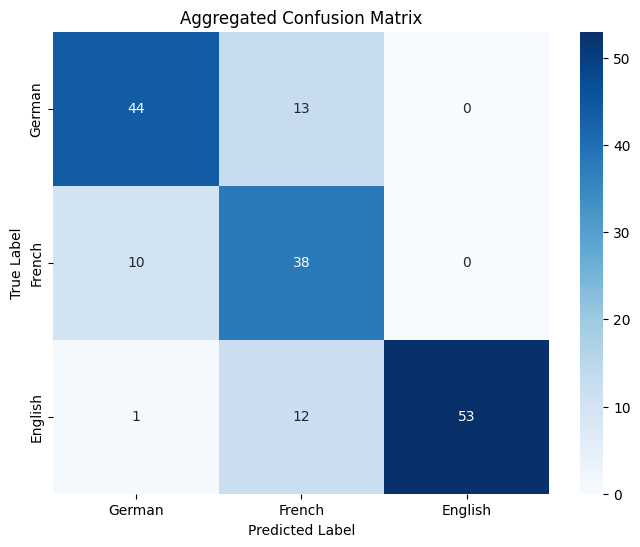

In [ ]:
print("\nAggregated Confusion Matrix Across All Folds:")

if 'confusion_matrices' in results_aggregator and results_aggregator['confusion_matrices']:
    # Sum the confusion matrices from all folds
    total_cm = np.sum(np.array(results_aggregator['confusion_matrices']), axis=0)

    class_labels = ['German', 'French', 'English']

    plt.figure(figsize=(8, 6))
    sns.heatmap(total_cm, annot=True, fmt='g', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Aggregated Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
else:
    print("No confusion matrix data available to plot.")

